# 1. Business Problem

## 1.1 Description

##### Source: https://www.kaggle.com/cmsk-redefining-cancer-treatment/

##### Data: Memorial Sloan Kettering Cancer Center (MSKCC)

##### Download training_variants.zip and training_text.zip from Kaggle.

Context:
##### Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

Problem statement :
###### Classify the given genetic variations/mutations based on evidence from text-based clinical literature.



## 1.2. Real-world/Business objectives and constraints.

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

# 2. Machine Learning Problem Formulation

## 2.1. Data

### 2.1.1. Data Overview

* Source: https://www.kaggle.com/cmsk-redefining-cancer-treatment/data
* We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations.
* Both these data files are have a common column called ID
* Data file's information:

    * training_variants (ID , Gene, Variations, Class)
    * training_text (ID, Text)

### 2.1.2. Example Data Point


---



##### training_variants


---
```
 ID,Gene,Variation,Class
 0,FAM58A,Truncating Mutations,1
 1,CBL,W802*,2
 2,CBL,Q249E,2
...
```

---
##### training_text



---
```
ID: 0
Text:
Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes.
CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been
identified and no kinase activity revealed. Previous work has shown that CDK10 silencing
increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of
the MAPK pathway, which confers tamoxifen resistance to breast cancer cells.
The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the
functions of CDK10, remain elusive.
Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an
activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations
cause STAR syndrome, a human developmental anomaly whose features include toe
syndactyly, telecanthus, and anogenital and renal malformations.
...

```


---




## 2.2. Mapping the real-world problem to an ML problem




#### 2.2.1. Type of Machine Learning Problem
There are nine different classes a genetic mutation can be classified into => Multi class classification problem.

### 2.2.2. Performance Metric
##### Source: https://www.kaggle.com/cmsk-redefining-cancer-treatment#evaluation


##### Metric(s):

* Multi class log-loss
* Confusion matrix

### 2.2.3. Machine Learing Objectives and Constraints
##### Objective: Predict the probability of each data-point belonging to each of the nine classes.

##### Constraints:

* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

## 2.3. Train, CV and Test Datasets
Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

# 3. Exploratory Data Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

## 3.1. Reading Data

### 3.1.1. Reading Gene and Variation Data

In [4]:
data = pd.read_csv('/content/drive/MyDrive/PersonalisedCancerDiagnosis/training_variants')
print("Number of data points : ", data.shape[0])
print("Number of features : ", data.shape[1])
print("Features : ", data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### 3.1.2. Reading Text Data

In [5]:
# note the seprator in this file
data_text =pd.read_csv("/content/drive/MyDrive/PersonalisedCancerDiagnosis/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Preprocessing of text

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

In [8]:
#text processing stage.
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755


In [9]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## 3.1.4. Test, Train and Cross Validation Split

#### 3.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [13]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets

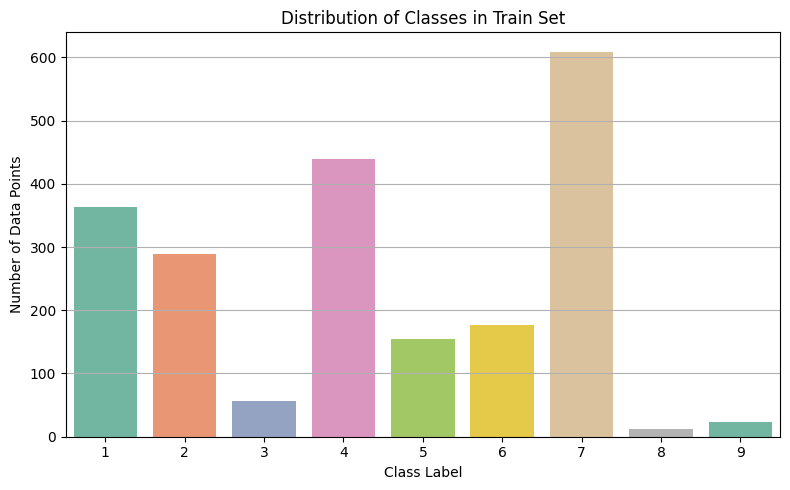

Number of data points in class 7 : 609 (28.672%)
Number of data points in class 4 : 439 (20.669%)
Number of data points in class 1 : 363 (17.09%)
Number of data points in class 2 : 289 (13.606%)
Number of data points in class 6 : 176 (8.286%)
Number of data points in class 5 : 155 (7.298%)
Number of data points in class 3 : 57 (2.684%)
Number of data points in class 9 : 24 (1.13%)
Number of data points in class 8 : 12 (0.565%)
--------------------------------------------------------------------------------


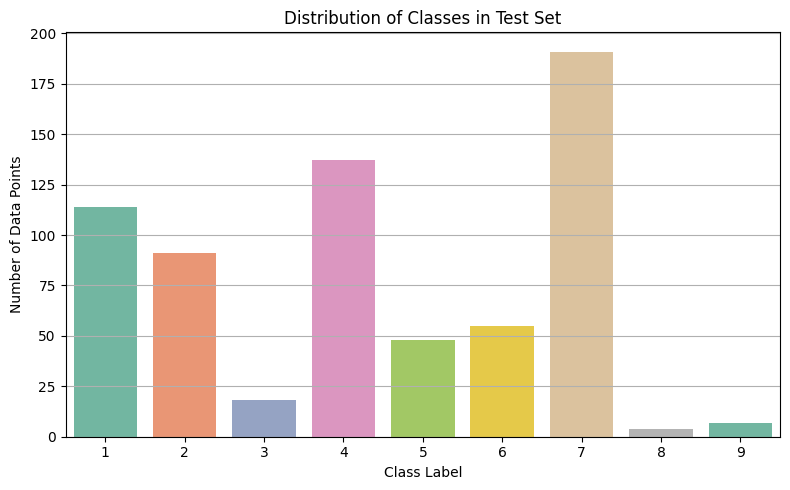

Number of data points in class 7 : 191 (28.722%)
Number of data points in class 4 : 137 (20.602%)
Number of data points in class 1 : 114 (17.143%)
Number of data points in class 2 : 91 (13.684%)
Number of data points in class 6 : 55 (8.271%)
Number of data points in class 5 : 48 (7.218%)
Number of data points in class 3 : 18 (2.707%)
Number of data points in class 9 : 7 (1.053%)
Number of data points in class 8 : 4 (0.602%)
--------------------------------------------------------------------------------


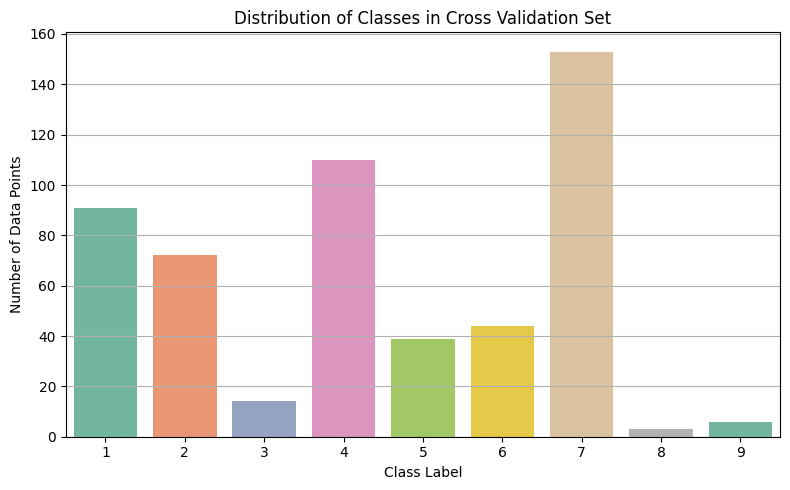

Number of data points in class 7 : 153 (28.759%)
Number of data points in class 4 : 110 (20.677%)
Number of data points in class 1 : 91 (17.105%)
Number of data points in class 2 : 72 (13.534%)
Number of data points in class 6 : 44 (8.271%)
Number of data points in class 5 : 39 (7.331%)
Number of data points in class 3 : 14 (2.632%)
Number of data points in class 9 : 6 (1.128%)
Number of data points in class 8 : 3 (0.564%)
--------------------------------------------------------------------------------


In [15]:
# Function to plot class distribution
def plot_class_distribution(data, dataset_name, total_samples):
    # Create a DataFrame from the distribution dict
    dist_df = data.reset_index()
    dist_df.columns = ['Class', 'Count']

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=dist_df, x='Class', y='Count', palette='Set2')
    plt.title(f'Distribution of Classes in {dataset_name} Set')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Data Points')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Print stats sorted by class count (descending)
    sorted_yi = np.argsort(-data.values)
    for i in sorted_yi:
        class_label = data.index[i]
        count = data.values[i]
        percent = np.round((count / total_samples) * 100, 3)
        print(f"Number of data points in class {class_label} : {count} ({percent}%)")
    print('-' * 80)

# Get distributions
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

# Plot each with summary
plot_class_distribution(train_class_distribution, 'Train', train_df.shape[0])
plot_class_distribution(test_class_distribution, 'Test', test_df.shape[0])
plot_class_distribution(cv_class_distribution, 'Cross Validation', cv_df.shape[0])

### 3.2 Prediction using a 'Random' Model

In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A = (((C.T) / (C.sum(axis=1))).T)
    # divide each element of the confusion matrix with the sum of elements in that row

    # Example:
    # C = [[1, 2],
    #      [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis=1) = [3, 7]  # axis=1 corresponds to rows
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3],
    #                              [3/7, 4/7]]
    # sum of row elements = 1

    B = (C / C.sum(axis=0))
    # divide each element of the confusion matrix with the sum of elements in that column
    # C = [[1, 2],
    #      [3, 4]]
    # C.sum(axis=0) = [4, 6]  # axis=0 corresponds to columns
    # C / C.sum(axis=0) = [[1/4, 2/6],
    #                      [3/4, 4/6]]

    labels = list(range(1, 10))  # class labels 1 to 9

    # Representing original confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(C, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

    # Representing Precision matrix (column-wise normalized)
    plt.figure(figsize=(8, 5))
    sns.heatmap(B, annot=True, cmap="YlOrBr", fmt=".2f", xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Precision'})
    plt.title("Precision matrix (Column Sum=1)")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

    # Representing Recall matrix (row-wise normalized)
    plt.figure(figsize=(8, 5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Recall'})
    plt.title("Recall matrix (Row Sum=1)")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()

Log loss on Cross Validation Data using Random Model :  2.476289008813429
Log loss on Test Data using Random Model :  2.5528903908693006
------------------------------------------------------------------------------------------------------------------------


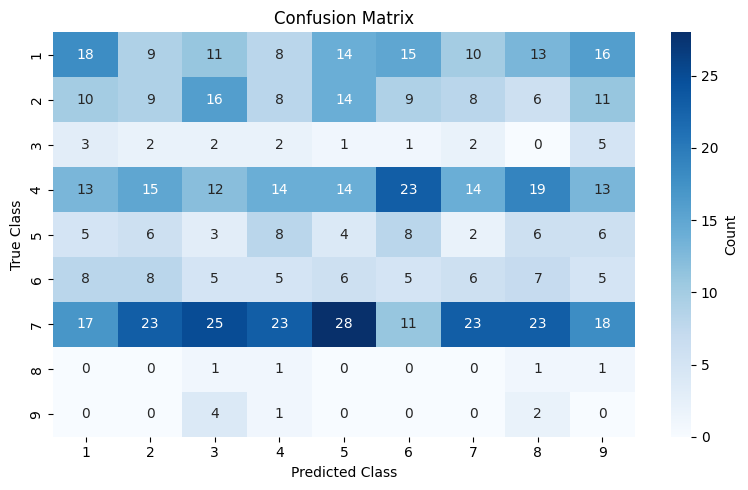

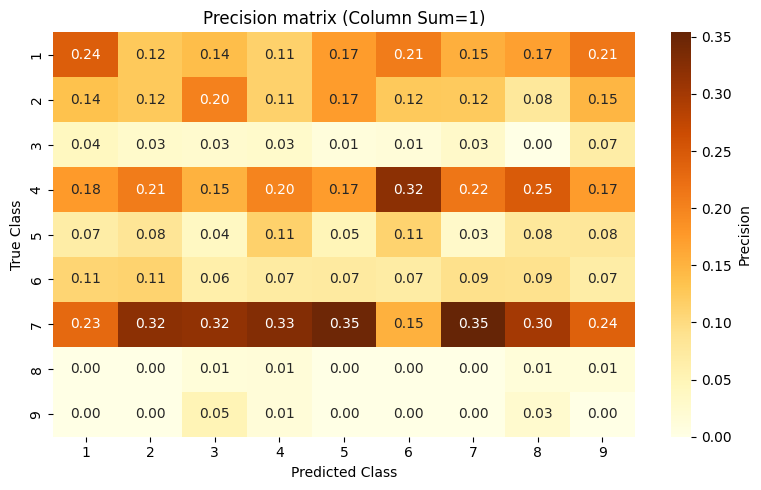

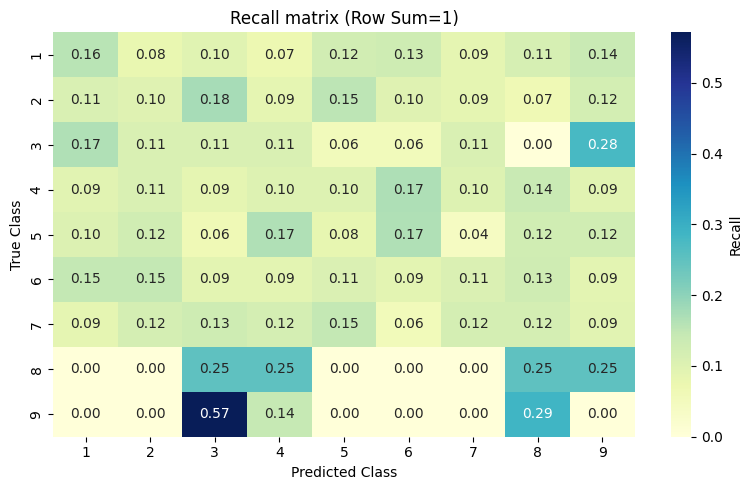

In [17]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model : ", log_loss(y_cv, cv_predicted_y))

# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model : ", log_loss(y_test, test_predicted_y))
print('-'*120)

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## 3.3 Univariate Analysis

In [18]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()

    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()

    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class
            # 2470  2470  BRCA1                S1715C      1
            # 2486  2486  BRCA1                S1841R      1
            # 2614  2614  BRCA1                   M1R      1
            # 2432  2432  BRCA1                L1657P      1
            # 2567  2567  BRCA1                T1685A      1
            # 2583  2583  BRCA1                E1660G      1
            # 2634  2634  BRCA1                W1718L      1
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]

            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788],
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837],
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816],
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608],
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289],
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912],
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()

    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing

* (numerator + 10\*alpha) / (denominator + 90\*alpha)



### 3.2.1 Univariate Analysis on Gene Feature

#### **Q1.** Gene, What type of feature it is ?
#### **Ans.** Gene is a categorical variable

#### Q2. How many categories are there and How they are distributed?

In [19]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 238
Gene
BRCA1     171
TP53      109
EGFR       92
PTEN       81
BRCA2      80
BRAF       60
KIT        59
ERBB2      47
ALK        47
PDGFRA     40
Name: count, dtype: int64


In [20]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 238 different categories of genes in the train data, and they are distibuted as follows


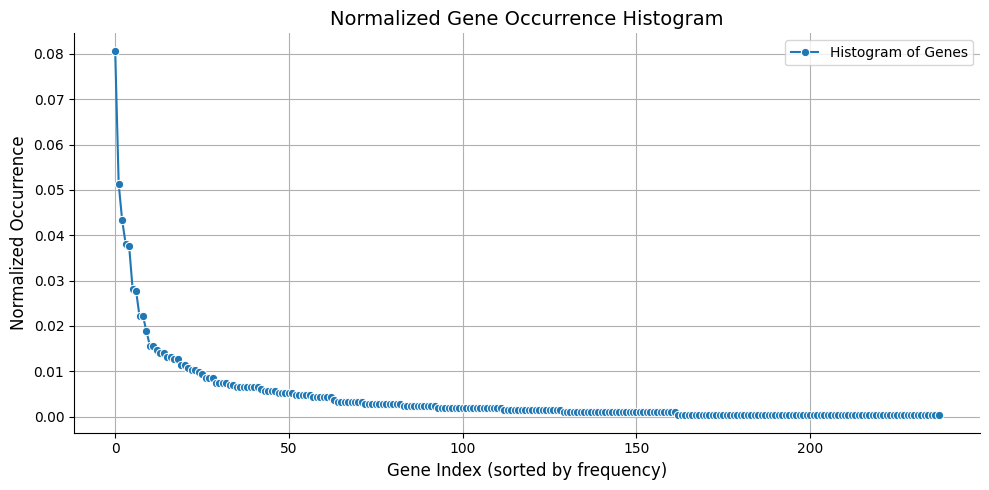

In [21]:
df = pd.DataFrame(list(unique_genes.items()), columns=["Gene", "Count"])

df["Normalized Count"] = df["Count"] / df["Count"].sum()
df = df.sort_values("Normalized Count", ascending=False).reset_index(drop=True)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df["Normalized Count"], marker="o", label="Histogram of Genes")
plt.xlabel("Gene Index (sorted by frequency)", fontsize=12)
plt.ylabel("Normalized Occurrence", fontsize=12)
plt.title("Normalized Gene Occurrence Histogram", fontsize=14)
plt.legend()
plt.grid(True)
sns.despine()
plt.tight_layout()
plt.show()


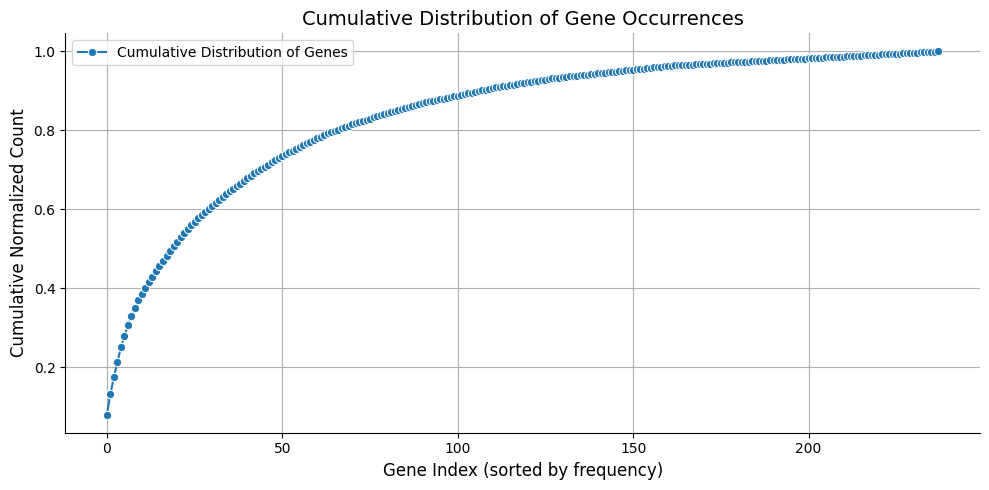

In [22]:
df["Cumulative Sum"] = df["Normalized Count"].cumsum()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df["Cumulative Sum"], marker='o', label='Cumulative Distribution of Genes')

plt.xlabel("Gene Index (sorted by frequency)", fontsize=12)
plt.ylabel("Cumulative Normalized Count", fontsize=12)
plt.title("Cumulative Distribution of Gene Occurrences", fontsize=14)
plt.grid(True)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

#### **Q3.** How to featurize this Gene feature?

#### **Ans**. There are two ways we can featurize this variable:

* One-hot Encoding
* Response Coding

#### We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic Regression, while response coding is better for Random Forests.

In [23]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [24]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [25]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [26]:
train_df['Gene'].head()

,Gene
2756,BRAF
3260,RET
249,EGFR
2234,PTEN
3165,RAF1


In [27]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'arid2', 'arid5b', 'asxl1',
       'asxl2', 'atm', 'atr', 'atrx', 'aurka', 'aurkb', 'axin1', 'axl',
       'b2m', 'bap1', 'bard1', 'bcl10', 'bcl2l11', 'bcor', 'braf',
       'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1',
       'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1', 'cdh1',
       'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a',
       'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp', 'ctcf', 'ctla4',
       'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'dusp4', 'egfr',
       'eif1ax', 'elf3', 'ep300', 'epas1', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fat1', 'fbxw7', 'fgf19',
       'fgf3', 'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt1', 'flt3',
       'foxa1', 'foxl2', 'foxo1', 'foxp1', 'gata3', 'gna11', 'gnas',
       'h3f3a', '

In [28]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 237)


#### **Q4.** How good is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For alpha = 1.0e-05, Log Loss = 1.19240
For alpha = 1.0e-04, Log Loss = 1.16974
For alpha = 1.0e-03, Log Loss = 1.20796
For alpha = 1.0e-02, Log Loss = 1.31442
For alpha = 1.0e-01, Log Loss = 1.43706
For alpha = 1.0e+00, Log Loss = 1.48612


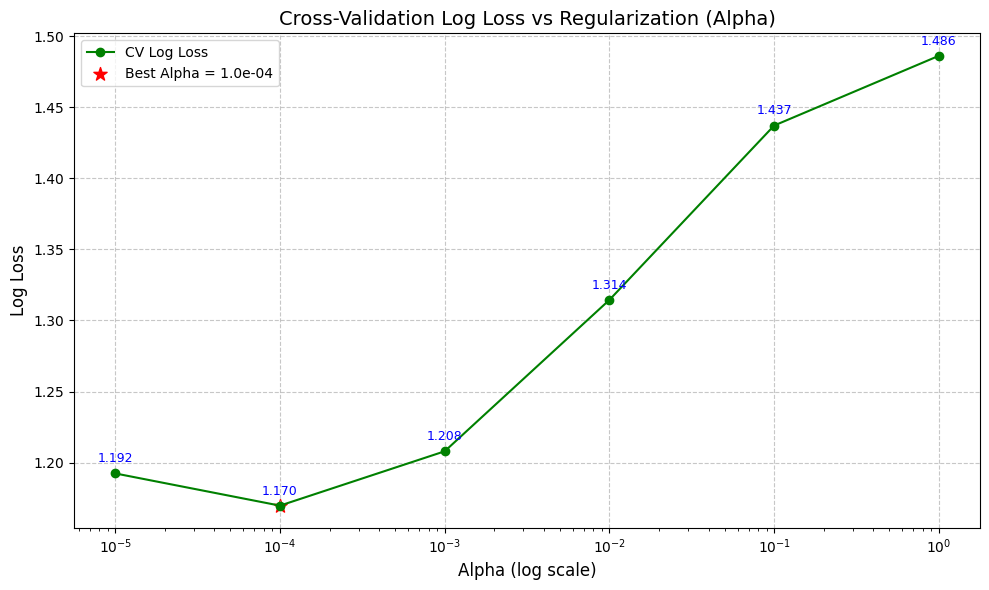


Best Alpha = 1.0e-04
Train Log Loss: 0.9980381644076384
CV Log Loss: 1.1697440512977744
Test Log Loss: 1.2050852290828864


In [29]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    log_err = log_loss(y_cv, predict_y, labels=clf.classes_)
    cv_log_error_array.append(log_err)

    print(f"For alpha = {i:.1e}, Log Loss = {log_err:.5f}")

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(alpha, cv_log_error_array, color='green', marker='o', linestyle='-', label='CV Log Loss')

for i, log_err in enumerate(cv_log_error_array):
    ax.annotate(f'{log_err:.3f}',
                (alpha[i], log_err),
                textcoords="offset points",
                xytext=(0, 8),
                ha='center',
                fontsize=9,
                color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(best_alpha_val, cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.1e}')

ax.set_xscale('log')

ax.set_title("Cross-Validation Log Loss vs Regularization (Alpha)", fontsize=14)
ax.set_xlabel("Alpha (log scale)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

clf = SGDClassifier(alpha=best_alpha_val, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y_train = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print(f"\nBest Alpha = {best_alpha_val:.1e}")
print("Train Log Loss:", log_loss(y_train, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print("CV Log Loss:", log_loss(y_cv, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y_test, labels=clf.classes_))

#### **Q5.** Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

#### **Ans.** Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [30]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  238  genes in train dataset?
Ans
1. In test data 644 out of 665 : 96.84210526315789
2. In cross validation data 516 out of  532 : 96.99248120300751


### 3.2.2 Univariate Analysis on Variation Feature

#### **Q7.** Variation, What type of feature is it ?

#### **Ans.** Variation is a categorical variable


#### **Q8.** How many categories are there?

In [31]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1929
Variation
Truncating Mutations    57
Amplification           52
Deletion                48
Fusions                 19
Overexpression           5
E17K                     3
Q61H                     2
G12D                     2
TMPRSS2-ETV1 Fusion      2
T167A                    2
Name: count, dtype: int64


In [32]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1929 different categories of variations in the train data, and they are distibuted as follows


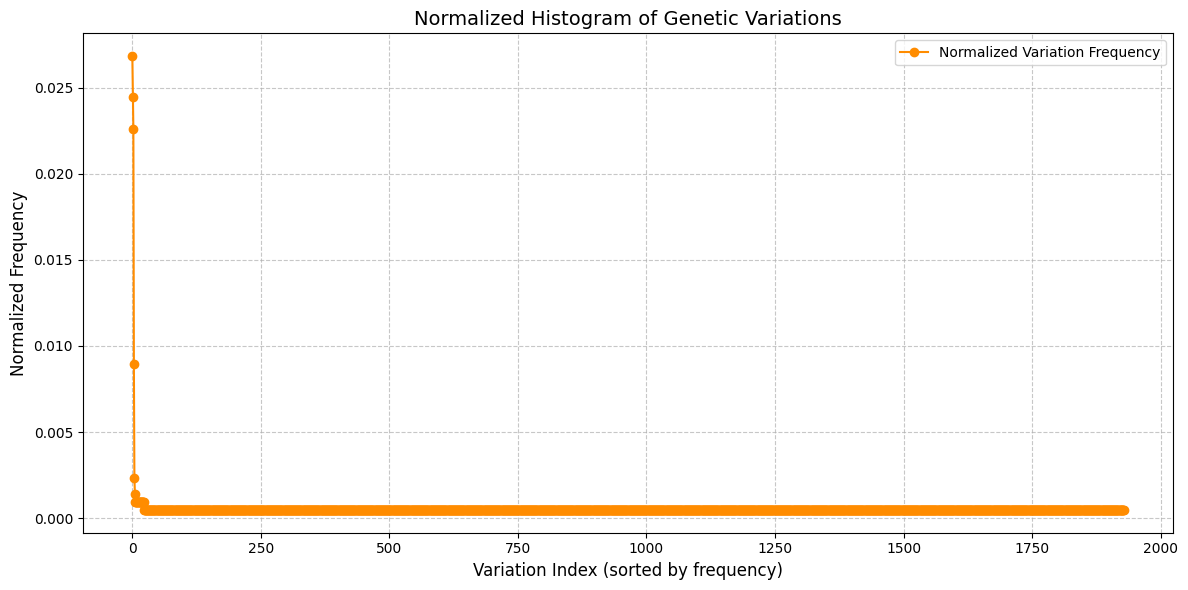

In [33]:
variation_values = unique_variations.values
variation_keys = unique_variations.index.tolist()

s = variation_values.sum()
h = variation_values / s

sorted_indices = np.argsort(h)[::-1]
h_sorted = h[sorted_indices]

plt.figure(figsize=(12, 6))
plt.plot(h_sorted, marker='o', linestyle='-', color='darkorange', label="Normalized Variation Frequency")

plt.title("Normalized Histogram of Genetic Variations", fontsize=14)
plt.xlabel("Variation Index (sorted by frequency)", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

[0.02683616 0.05131827 0.07391714 ... 0.99905838 0.99952919 1.        ]


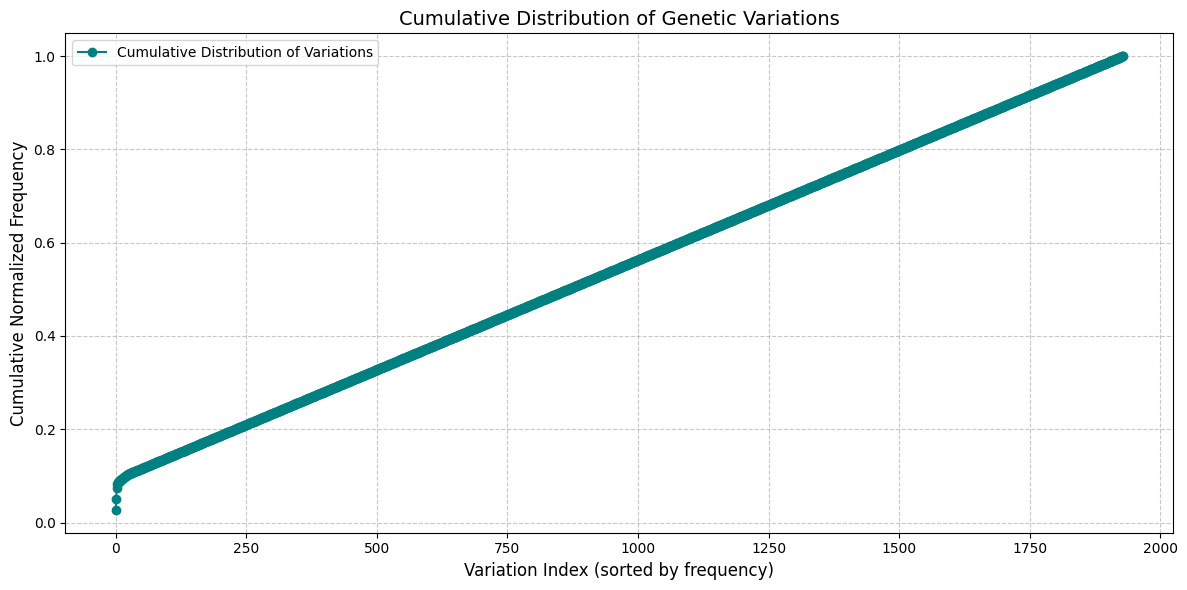

In [34]:
c = np.cumsum(h_sorted)
print(c)

plt.figure(figsize=(12, 6))
plt.plot(c, marker='o', linestyle='-', color='teal', label='Cumulative Distribution of Variations')

plt.title("Cumulative Distribution of Genetic Variations", fontsize=14)
plt.xlabel("Variation Index (sorted by frequency)", fontsize=12)
plt.ylabel("Cumulative Normalized Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

#### **Q9.** How to featurize this Variation feature?

#### **Ans.** There are two ways we can featurize this variable:

* One-hot Encoding
* Response Coding

We will be using both these methods to featurize the Variation feature.

In [35]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [36]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [37]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [38]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1958)


#### **Q10.** How good is this Variation feature in predicting y_i?

Let's build a model just like the earlier!

For alpha = 1.0e-05, Log Loss = 1.72019
For alpha = 1.0e-04, Log Loss = 1.71879
For alpha = 1.0e-03, Log Loss = 1.72364
For alpha = 1.0e-02, Log Loss = 1.73823
For alpha = 1.0e-01, Log Loss = 1.74529
For alpha = 1.0e+00, Log Loss = 1.74475


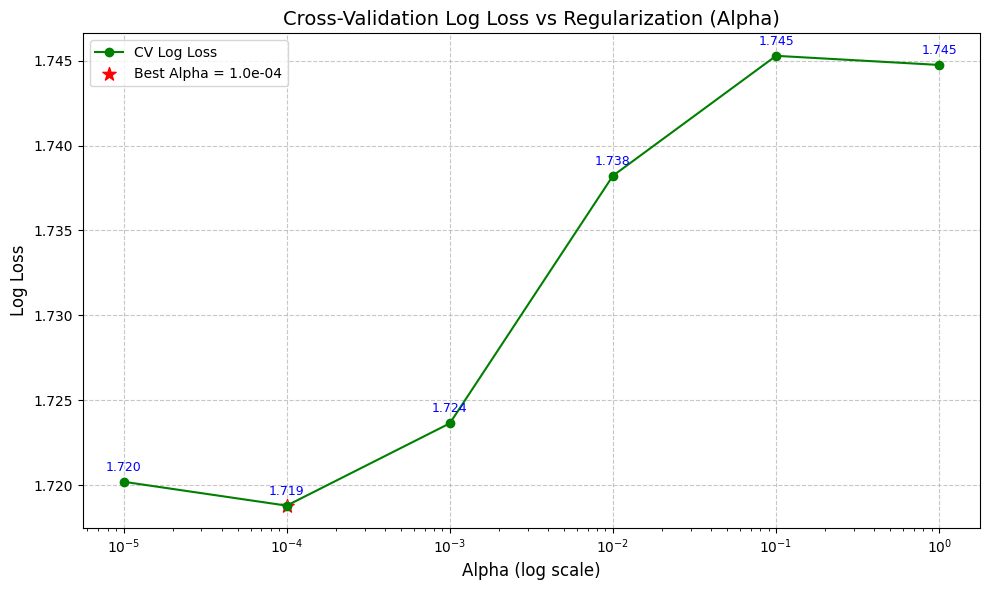


Best Alpha = 1.0e-04
Train Log Loss: 0.7281885338741116
CV Log Loss: 1.7187870596621526
Test Log Loss: 1.6685226636493824


In [39]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    log_err = log_loss(y_cv, predict_y, labels=clf.classes_)
    cv_log_error_array.append(log_err)

    print(f"For alpha = {i:.1e}, Log Loss = {log_err:.5f}")

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(alpha, cv_log_error_array, color='green', marker='o', linestyle='-', label='CV Log Loss')

for i, log_err in enumerate(cv_log_error_array):
    ax.annotate(f'{log_err:.3f}',
                (alpha[i], log_err),
                textcoords="offset points",
                xytext=(0, 8),
                ha='center',
                fontsize=9,
                color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(best_alpha_val, cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.1e}')

ax.set_xscale('log')

ax.set_title("Cross-Validation Log Loss vs Regularization (Alpha)", fontsize=14)
ax.set_xlabel("Alpha (log scale)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

clf = SGDClassifier(alpha=best_alpha_val, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y_train = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print(f"\nBest Alpha = {best_alpha_val:.1e}")
print("Train Log Loss:", log_loss(y_train, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print("CV Log Loss:", log_loss(y_cv, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y_test, labels=clf.classes_))

#### **Q11.** Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

#### **Ans.** Not sure! But lets be very sure using the below analysis.

In [40]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1929  genes in test and cross validation data sets?
Ans
1. In test data 83 out of 665 : 12.481203007518797
2. In cross validation data 43 out of  532 : 8.082706766917292


### 3.2.3 Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [41]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [42]:
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [43]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53506


In [44]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [45]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [46]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [47]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [48]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [49]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.int64(3): 5961, np.int64(4): 3481, np.int64(6): 2886, np.int64(5): 2721, np.int64(7): 2156, np.int64(8): 1787, np.int64(10): 1693, np.int64(9): 1522, np.int64(12): 1345, np.int64(11): 1334, np.int64(14): 1159, np.int64(13): 932, np.int64(15): 750, np.int64(16): 696, np.int64(18): 689, np.int64(20): 684, np.int64(19): 567, np.int64(17): 548, np.int64(24): 529, np.int64(21): 519, np.int64(22): 480, np.int64(26): 432, np.int64(28): 384, np.int64(39): 366, np.int64(23): 363, np.int64(30): 335, np.int64(27): 319, np.int64(25): 317, np.int64(31): 305, np.int64(49): 294, np.int64(33): 283, np.int64(36): 275, np.int64(40): 270, np.int64(29): 264, np.int64(32): 251, np.int64(35): 236, np.int64(34): 231, np.int64(38): 219, np.int64(42): 210, np.int64(37): 195, np.int64(45): 184, np.int64(46): 173, np.int64(41): 173, np.int64(51): 167, np.int64(44): 163, np.int64(48): 161, np.int64(52): 156, np.int64(50): 152, np.int64(60): 143, np.int64(56): 141, np.int64(54): 141, np.int64(43): 140,

For alpha = 1.0e-05, Log Loss = 1.29651
For alpha = 1.0e-04, Log Loss = 1.12995
For alpha = 1.0e-03, Log Loss = 1.11656
For alpha = 1.0e-02, Log Loss = 1.19795
For alpha = 1.0e-01, Log Loss = 1.43354
For alpha = 1.0e+00, Log Loss = 1.62879


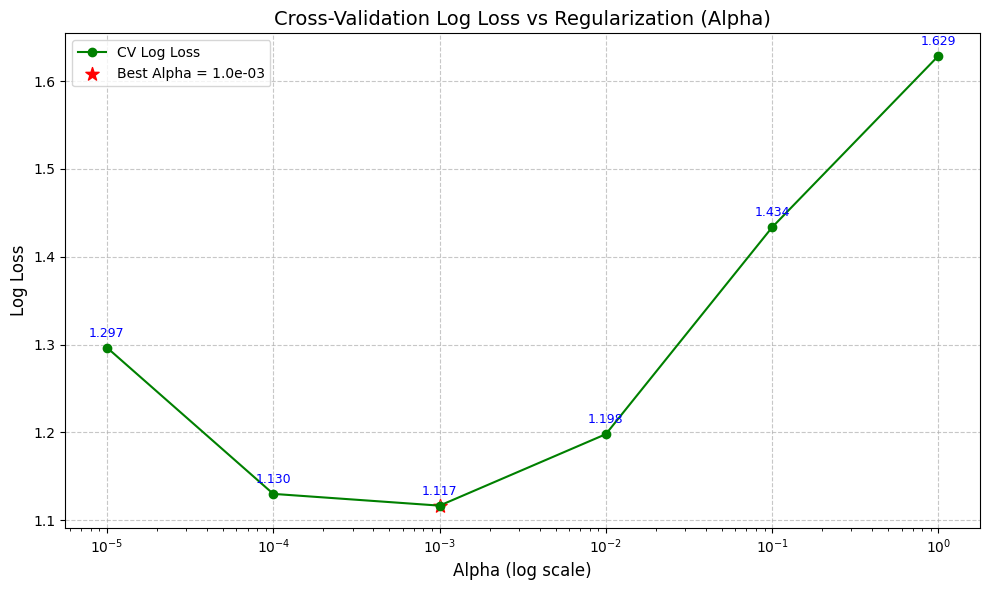


Best Alpha = 1.0e-03
Train Log Loss: 0.6612175145650904
CV Log Loss: 1.1165584373260447
Test Log Loss: 1.1689753154496123


In [50]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)

    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    log_err = log_loss(y_cv, predict_y, labels=clf.classes_)
    cv_log_error_array.append(log_err)

    print(f"For alpha = {i:.1e}, Log Loss = {log_err:.5f}")

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(alpha, cv_log_error_array, color='green', marker='o', linestyle='-', label='CV Log Loss')

for i, log_err in enumerate(cv_log_error_array):
    ax.annotate(f'{log_err:.3f}',
                (alpha[i], log_err),
                textcoords="offset points",
                xytext=(0, 8),
                ha='center',
                fontsize=9,
                color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(best_alpha_val, cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.1e}')

ax.set_xscale('log')

ax.set_title("Cross-Validation Log Loss vs Regularization (Alpha)", fontsize=14)
ax.set_xlabel("Alpha (log scale)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

clf = SGDClassifier(alpha=best_alpha_val, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y_train = sig_clf.predict_proba(train_text_feature_onehotCoding)
print(f"\nBest Alpha = {best_alpha_val:.1e}")
print("Train Log Loss:", log_loss(y_train, predict_y_train, labels=clf.classes_))

predict_y_cv = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("CV Log Loss:", log_loss(y_cv, predict_y_cv, labels=clf.classes_))

predict_y_test = sig_clf.predict_proba(test_text_feature_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y_test, labels=clf.classes_))

#### **Q.** Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

#### **Ans.** Yes, it seems like!



In [51]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [52]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.408 % of word of test data appeared in train data
98.864 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [53]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [54]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs)

In [55]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    from sklearn.feature_extraction.text import CountVectorizer

    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_vec.get_feature_names_out())

    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names_out()[v]
            yes_no = (word == gene)
            if yes_no:
                word_present += 1
                print(f"{i} Gene feature [{word}] present in test data point [{yes_no}]")
        elif v < fea1_len + fea2_len:
            word = var_vec.get_feature_names_out()[v - fea1_len]
            yes_no = (word == var)
            if yes_no:
                word_present += 1
                print(f"{i} Variation feature [{word}] present in test data point [{yes_no}]")
        else:
            word = text_vec.get_feature_names_out()[v - fea1_len - fea2_len]
            yes_no = word in text.split()
            if yes_no:
                word_present += 1
                print(f"{i} Text feature [{word}] present in test data point [{yes_no}]")

    print(f"Out of the top {no_features} features, {word_present} are present in the query point")

## Stacking the three types of features

In [56]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2],
#      [3, 4]]
# b = [[4, 5],
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [57]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55701)
(number of data points * number of features) in test data =  (665, 55701)
(number of data points * number of features) in cross validation data = (532, 55701)


In [58]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [59]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model

### 4.1.1. Naive Bayes

**4.1.1.1. Hyper parameter**

For alpha = 1e-05
Log Loss: 1.2791521672613195
For alpha = 0.0001
Log Loss: 1.2739250540797196
For alpha = 0.001
Log Loss: 1.2688472373804327
For alpha = 0.1
Log Loss: 1.2303715999056604
For alpha = 1
Log Loss: 1.2867258420822087
For alpha = 10
Log Loss: 1.3483971636833991
For alpha = 100
Log Loss: 1.308658192820598
For alpha = 1000
Log Loss: 1.2772750907250288


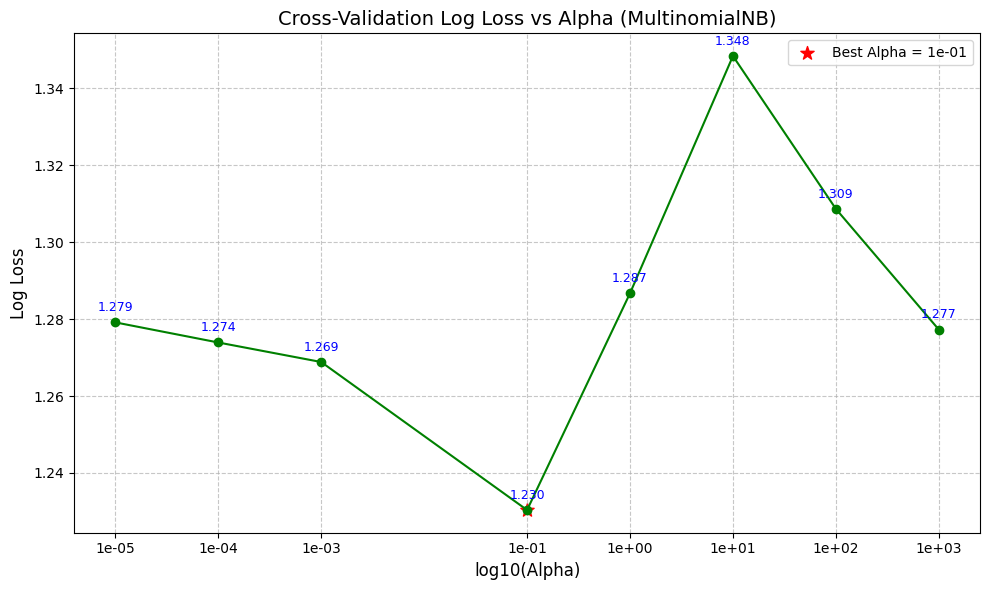


Best Alpha = 0.1
Train Log Loss: 0.8718422893613001
CV Log Loss: 1.2303715999056604
Test Log Loss: 1.2595516702262468


In [60]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    err = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(err)

    print("Log Loss:", err)

log_alphas = np.log10(alpha)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(log_alphas, cv_log_error_array, color='green', marker='o', linestyle='-')
ax.set_xticks(log_alphas)
ax.set_xticklabels([f'{a:.0e}' for a in alpha])
ax.set_title("Cross-Validation Log Loss vs Alpha (MultinomialNB)", fontsize=14)
ax.set_xlabel("log10(Alpha)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

for i, err in enumerate(cv_log_error_array):
    ax.annotate(f"{err:.3f}", (log_alphas[i], err), textcoords="offset points", xytext=(0, 8),
                ha='center', fontsize=9, color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(log_alphas[best_alpha_idx], cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.0e}')
ax.legend()
plt.tight_layout()
plt.show()

clf = MultinomialNB(alpha=best_alpha_val)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print(f"\nBest Alpha = {best_alpha_val}")
print("Train Log Loss:", log_loss(y_train, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("CV Log Loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y, labels=clf.classes_))

**4.1.1.2. Testing the model with best hyper paramters**

Log Loss: 1.2303715999056604
Number of misclassified points: 0.38533834586466165


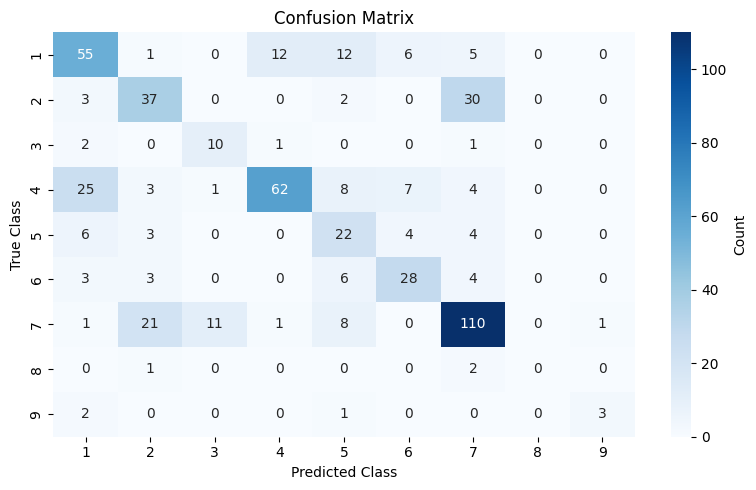

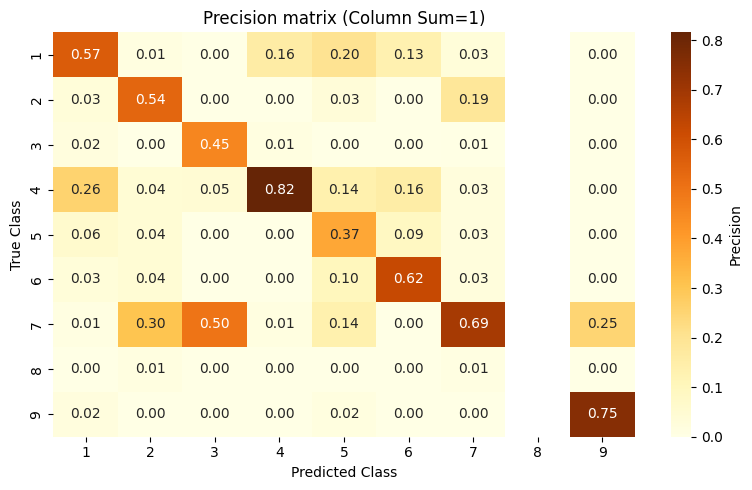

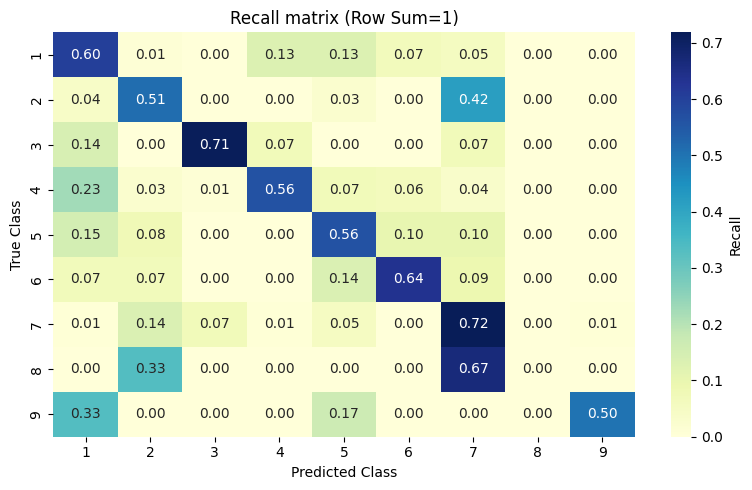

In [61]:
clf = MultinomialNB(alpha=best_alpha_val)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

print("Log Loss:", log_loss(cv_y, sig_clf_probs))
print("Number of misclassified points:",
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding) - cv_y)) / cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))


**4.1.1.3. Feature Importance, Correctly classified point**

In [62]:
no_feature = 100
test_point_index = 1
x_test_point = test_x_onehotCoding[test_point_index:test_point_index+1]

predicted_cls = sig_clf.predict(x_test_point)
print("Predicted Class:", predicted_cls[0])

probs = sig_clf.predict_proba(x_test_point)
print("Predicted Class Probabilities:", np.round(probs, 4))

print("Actual Class:", test_y[test_point_index])

log_prob = clf.feature_log_prob_

top_feature_indices = np.argsort(-log_prob[predicted_cls[0]])[:no_feature]

print("-" * 50)

get_impfeature_names(
    top_feature_indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)


Predicted Class: 7
Predicted Class Probabilities: [[0.0788 0.1629 0.0147 0.1014 0.0355 0.0375 0.5594 0.0055 0.0043]]
Actual Class: 7
--------------------------------------------------
Out of the top 100 features, 0 are present in the query point


In [63]:
test_df['TEXT'].iloc[test_point_index]

'oncogenic mutations neuroblastoma rat sarcoma oncogene nras frequent melanoma also found several cancer types lung cancer neuroblastoma colon cancer designed study analyze changes nras mutant tumor cells derived malignancies melanoma variety small molecule inhibitors well combinations tested order find beneficial inhibitory modalities nrasq61 mutant lung cancer neuroblastoma cell lines signaling changes incubation inhibitors studied compared found nras mutant melanoma cell lines sensitive inhibition mapk pathway mek inhibitor trametinib mek akt mek cdk4 6 inhibitor combinations show beneficial effects vitro however observed strong synergism combining mek pi3k mtor inhibitors cell lines study provides evidence nras mutant cancers share signaling similarities across different malignancies demonstrate dual pathway inhibition mapk pi3k akt mtor pathway synergistically reduces cell viability nras mutant cancers regardless tissue origin results suggest inhibitor combinations may potential t

In [64]:
no_feature

100

In [65]:
test_df['Gene'].iloc[test_point_index]

'NRAS'

In [66]:
test_df['Variation'].iloc[test_point_index]

'Q61R'

In [90]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    fea1_len = len(gene_vec.get_feature_names_out())
    fea2_len = len(var_vec.get_feature_names_out())

    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names_out()[v]
            yes_no = (word == gene)
            if yes_no:
                word_present += 1
                print(f"{i} Gene feature [{word}] present in test data point [{yes_no}]")
        elif v < fea1_len + fea2_len:
            word = var_vec.get_feature_names_out()[v - fea1_len]
            yes_no = (word == var)
            if yes_no:
                word_present += 1
                print(f"{i} Variation feature [{word}] present in test data point [{yes_no}]")
        else:
            word = text_vec.get_feature_names_out()[v - fea1_len - fea2_len]
            yes_no = word in text.split()
            if yes_no:
                word_present += 1
                print(f"{i} Text feature [{word}] present in test data point [{yes_no}]")

    print(f"Out of the top {no_features} features, {word_present} are present in the query point")

## 4.2 K-NN

### 4.2.1. Hyper parameter tuning

for alpha = 5
Log Loss : 1.0534099657707023
for alpha = 11
Log Loss : 1.0619570466656862
for alpha = 15
Log Loss : 1.0605974617165796
for alpha = 21
Log Loss : 1.053069723896915
for alpha = 31
Log Loss : 1.0653672165817603
for alpha = 41
Log Loss : 1.0575999900307633
for alpha = 51
Log Loss : 1.0577900897038552
for alpha = 99
Log Loss : 1.0655441065065177


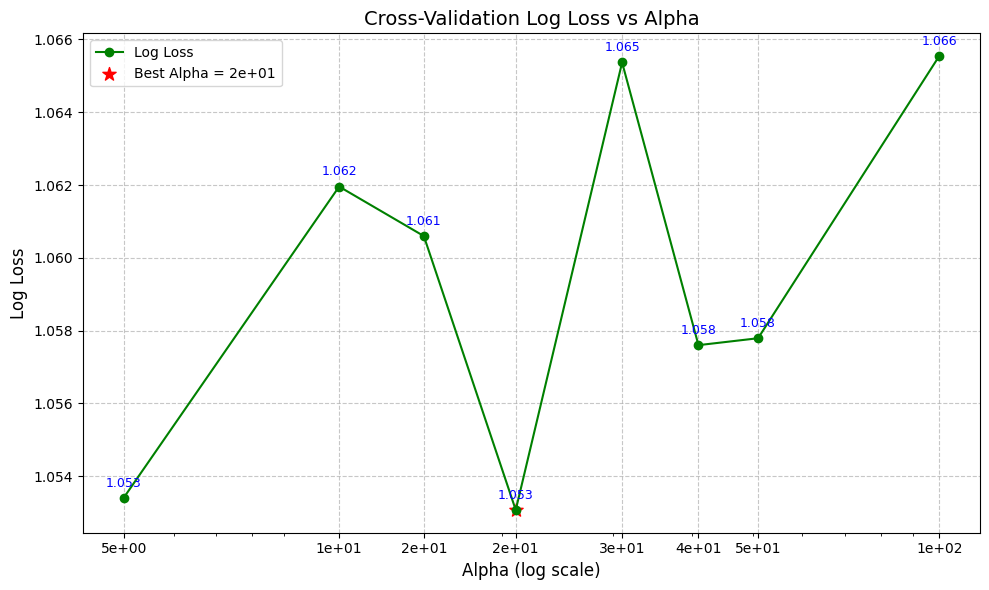

For values of best alpha =  21 The train log loss is: 0.7215577371667943
For values of best alpha =  21 The cross validation log loss is: 1.053069723896915
For values of best alpha =  21 The test log loss is: 1.068636848626151


In [79]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2,
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(alpha, cv_log_error_array, marker='o', linestyle='-', color='green', label='Log Loss')

for i, log_err in enumerate(cv_log_error_array):
    ax.annotate(f"{log_err:.3f}",
                (alpha[i], log_err),
                textcoords="offset points",
                xytext=(0, 8),
                ha='center',
                fontsize=9,
                color='blue')
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(best_alpha_val, cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*',
           label=f'Best Alpha = {best_alpha_val:.0e}')

ax.set_xscale('log')
ax.set_xticks(alpha)
ax.set_xticklabels([f"{a:.0e}" for a in alpha])

ax.set_title("Cross-Validation Log Loss vs Alpha", fontsize=14)
ax.set_xlabel("Alpha (log scale)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 4.2.2. Testing the model with best hyper paramters

Log loss : 1.053069723896915
Number of mis-classified points : 0.35714285714285715


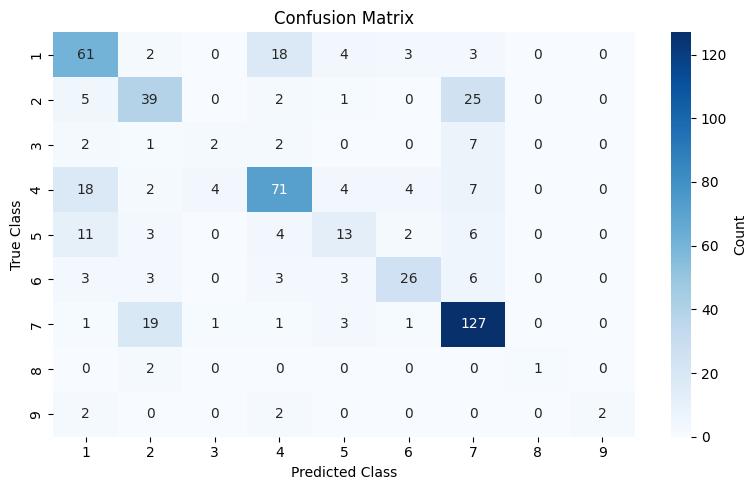

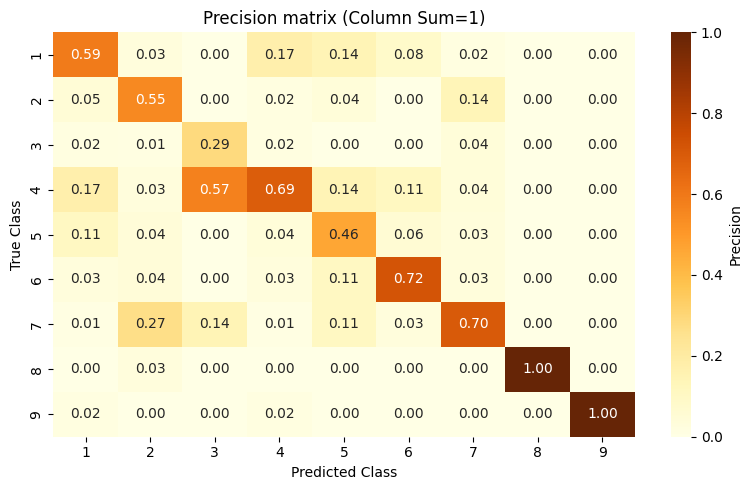

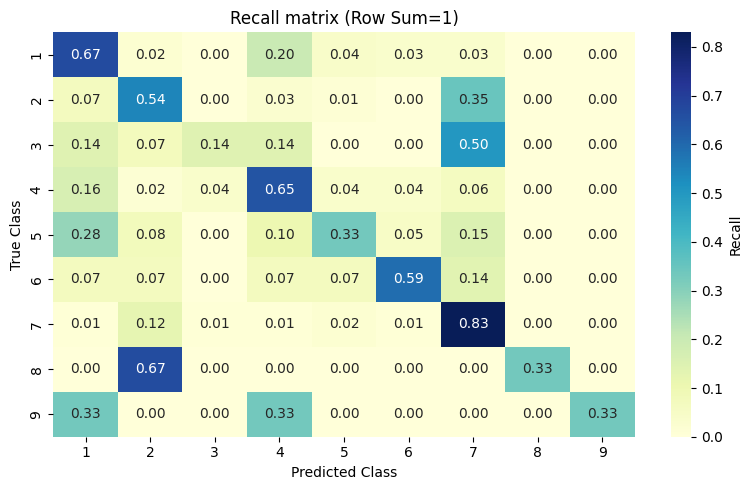

In [80]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

#### **4.2.3.Sample Query point -1**

In [81]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  21  nearest neighbours of the test points belongs to classes [7 7 7 7 7 2 7 7 7 7 2 2 7 7 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({np.int64(7): 18, np.int64(2): 3})


#### **4.2.4. Sample Query Point-2**

In [82]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 5
the k value for knn is 21 and the nearest neighbours of the test points belongs to classes [1 5 5 5 3 6 4 4 4 4 4 1 1 5 4 4 4 1 4 6 4]
Fequency of nearest points : Counter({np.int64(4): 10, np.int64(1): 4, np.int64(5): 4, np.int64(6): 2, np.int64(3): 1})


## 4.3. Logistic Regression

### 4.3.1. With Class balancing

**4.3.1.1. Hyper paramter tuning**

For alpha = 1e-06
Log Loss: 1.3071409916837415
For alpha = 1e-05
Log Loss: 1.3074014179351092
For alpha = 0.0001
Log Loss: 1.1116423107759785
For alpha = 0.001
Log Loss: 1.0748688634115604
For alpha = 0.01
Log Loss: 1.1098714033766848
For alpha = 0.1
Log Loss: 1.424770428127436
For alpha = 1
Log Loss: 1.6835407466154146
For alpha = 10
Log Loss: 1.7163118313580308
For alpha = 100
Log Loss: 1.7197508271834205


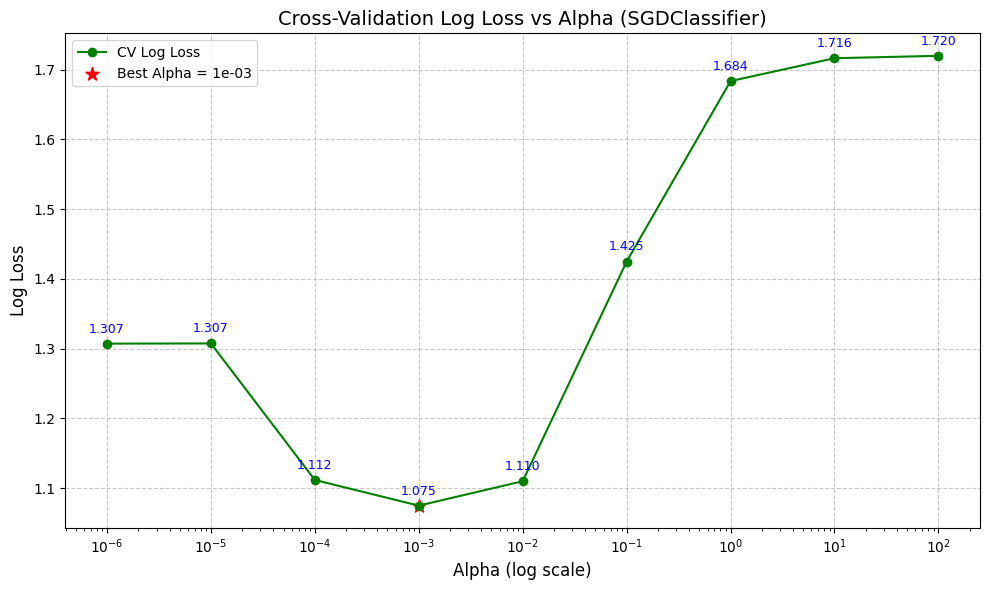


Best Alpha = 0.001
Train Log Loss: 0.5242683080205921
CV Log Loss: 1.0748688634115604
Test Log Loss: 1.0816856336120069


In [83]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)

    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    log_err = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)

    cv_log_error_array.append(log_err)
    print("Log Loss:", log_err)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(alpha, cv_log_error_array, color='green', marker='o', linestyle='-', label='CV Log Loss')

for i, err in enumerate(cv_log_error_array):
    ax.annotate(f"{err:.3f}",
                (alpha[i], err),
                textcoords="offset points",
                xytext=(0, 8),
                ha='center', fontsize=9, color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]

ax.scatter(best_alpha_val, cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.0e}')

ax.set_xscale('log')
ax.set_title("Cross-Validation Log Loss vs Alpha (SGDClassifier)", fontsize=14)
ax.set_xlabel("Alpha (log scale)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

clf = SGDClassifier(class_weight='balanced', alpha=best_alpha_val, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('\nBest Alpha =', best_alpha_val)
print("Train Log Loss:", log_loss(y_train, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("CV Log Loss:", log_loss(y_cv, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y, labels=clf.classes_))

#### **4.3.1.2. Testing the model with best hyper paramters**

Log loss : 1.0748688634115604
Number of mis-classified points : 0.34398496240601506


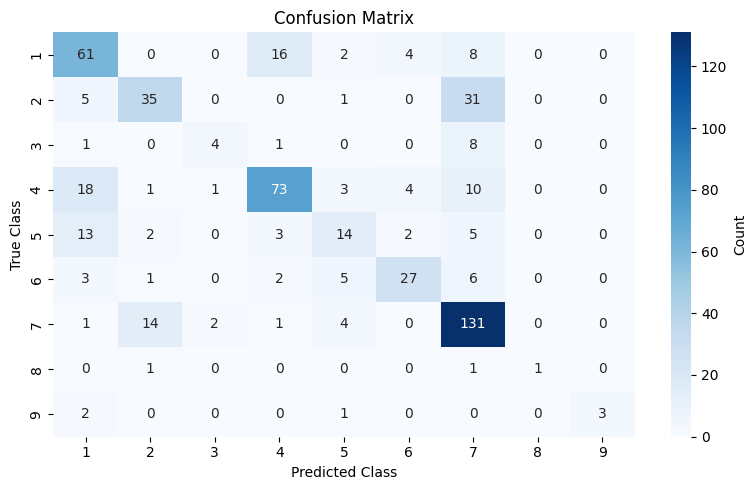

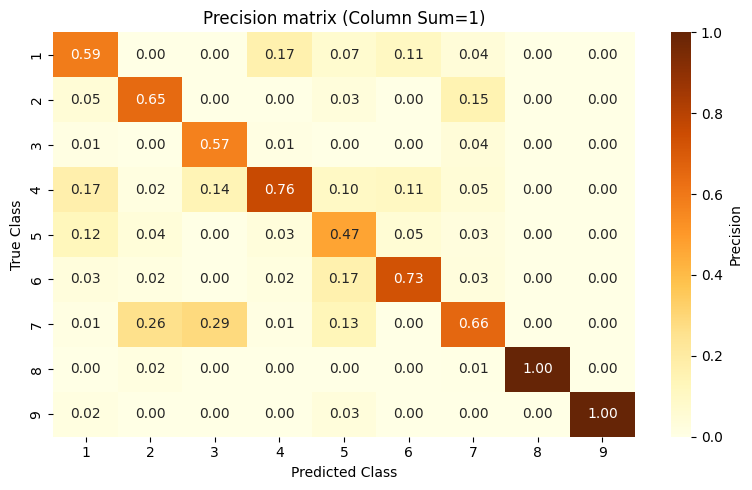

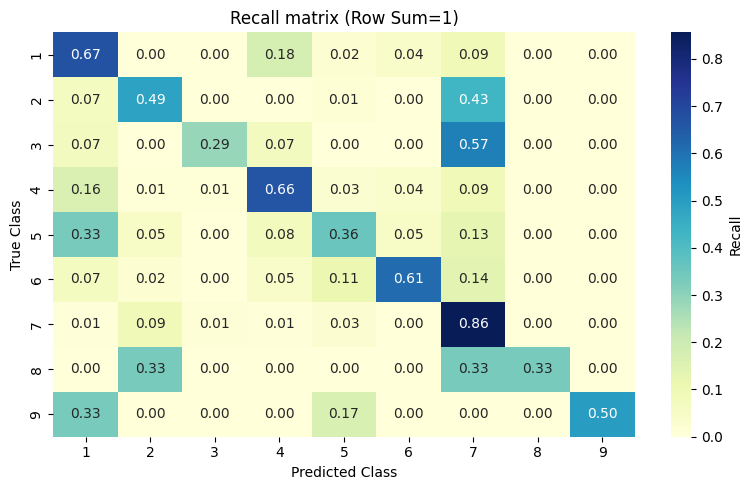

In [84]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

**4.3.1.3. Feature Importance**

In [107]:
from tabulate import tabulate

def get_imp_feature_names(text, indices, gene, var, no_features):
    word_present = 0
    tabulate_list = []
    incresingorder_ind = 0

    gene_feature_names = train_gene_vectorizer.get_feature_names_out()
    variation_feature_names = train_variation_vectorizer.get_feature_names_out()

    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            word = gene_feature_names[i]
            yes_no = (word == gene)
            if yes_no:
                word_present += 1
            tabulate_list.append([incresingorder_ind, word, yes_no])

        elif i < train_gene_feature_onehotCoding.shape[1] + train_variation_feature_onehotCoding.shape[1]:
            var_idx = i - train_gene_feature_onehotCoding.shape[1]
            word = variation_feature_names[var_idx]
            yes_no = (word == var)
            if yes_no:
                word_present += 1
            tabulate_list.append([incresingorder_ind, word, yes_no])

        else:
            text_idx = i - train_gene_feature_onehotCoding.shape[1] - train_variation_feature_onehotCoding.shape[1]
            if text_idx < len(train_text_features):
                word = train_text_features[text_idx]
                yes_no = word in text.split()
                if yes_no:
                    word_present += 1
                tabulate_list.append([incresingorder_ind, word, yes_no])

        incresingorder_ind += 1

    print(f"Out of the top {no_features} features, {word_present} are present in the query point\n")
    print(tabulate(tabulate_list, headers=["Index", "Feature Name", "Present or Not"]))

**4.3.1.3.1. Correctly Classified point**

In [111]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
no_feature = 100
x_test_point = test_x_onehotCoding[test_point_index:test_point_index+1]

predicted_cls = sig_clf.predict(x_test_point)
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(x_test_point), 4))
print("Actual Class:", test_y[test_point_index])

class_index = list(clf.classes_).index(predicted_cls[0])
indices = np.argsort(-1 * abs(clf.coef_[class_index]))[:no_feature]
print("-" * 50)

Predicted Class: 5
Predicted Class Probabilities: [[0.1582 0.0311 0.0349 0.21   0.3657 0.1725 0.0176 0.0067 0.0033]]
Actual Class: 5
--------------------------------------------------


**4.3.1.3.2. Incorrectly Classified point**

In [112]:
test_point_index = 5
no_feature = 100
x_test_point = test_x_onehotCoding[test_point_index:test_point_index+1]

predicted_cls = sig_clf.predict(x_test_point)
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(x_test_point), 4))
print("Actual Class:", test_y[test_point_index])

class_index = list(clf.classes_).index(predicted_cls[0])
indices = np.argsort(-1 * abs(clf.coef_[class_index]))[:no_feature]
print("-" * 50)

Predicted Class: 7
Predicted Class Probabilities: [[0.0116 0.0972 0.0014 0.0079 0.0094 0.0035 0.8629 0.0046 0.0015]]
Actual Class: 2
--------------------------------------------------


### 4.3.2. Without Class balancing

**4.3.2.1. Hyper paramter tuning**

For alpha = 1e-06
Log Loss: 1.3099033100927957
For alpha = 1e-05
Log Loss: 1.2860822778225571
For alpha = 0.0001
Log Loss: 1.1575793163410812
For alpha = 0.001
Log Loss: 1.086822011106921
For alpha = 0.01
Log Loss: 1.14068428747489
For alpha = 0.1
Log Loss: 1.3516906697068052
For alpha = 1
Log Loss: 1.5657704288060836


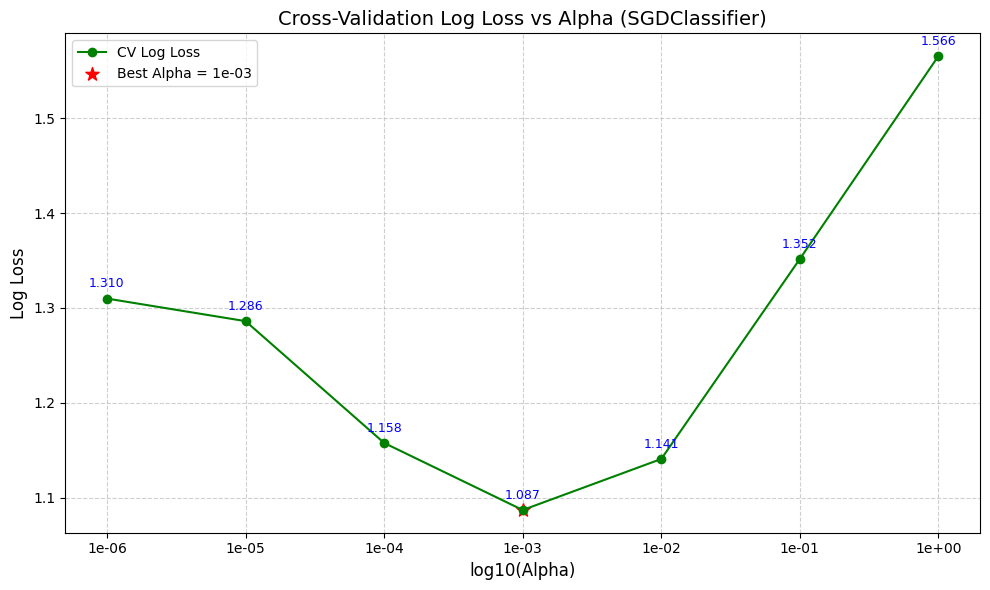


Training final model with best alpha = 0.001
Train Log Loss: 0.5261125059890712
CV Log Loss: 1.086822011106921
Test Log Loss: 1.0775266683396134


In [113]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    err = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(err)

    print("Log Loss:", err)

log_alphas = np.log10(alpha)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_alphas, cv_log_error_array, marker='o', linestyle='-', color='green', label='CV Log Loss')

for i, err in enumerate(cv_log_error_array):
    ax.annotate(f"{err:.3f}", (log_alphas[i], err), textcoords="offset points", xytext=(0, 8),
                ha='center', fontsize=9, color='blue')

best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(log_alphas[best_alpha_idx], cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.0e}')

ax.set_title("Cross-Validation Log Loss vs Alpha (SGDClassifier)", fontsize=14)
ax.set_xlabel("log10(Alpha)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xticks(log_alphas)
ax.set_xticklabels([f"{a:.0e}" for a in alpha])
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nTraining final model with best alpha = {best_alpha_val}")
clf = SGDClassifier(alpha=best_alpha_val, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print("Train Log Loss:", log_loss(train_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("CV Log Loss:", log_loss(cv_y, predict_y, labels=clf.classes_))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("Test Log Loss:", log_loss(y_test, predict_y, labels=clf.classes_))


#### **4.3.2.2. Testing model with best hyper parameters**

Log loss : 1.086822011106921
Number of mis-classified points : 0.34210526315789475


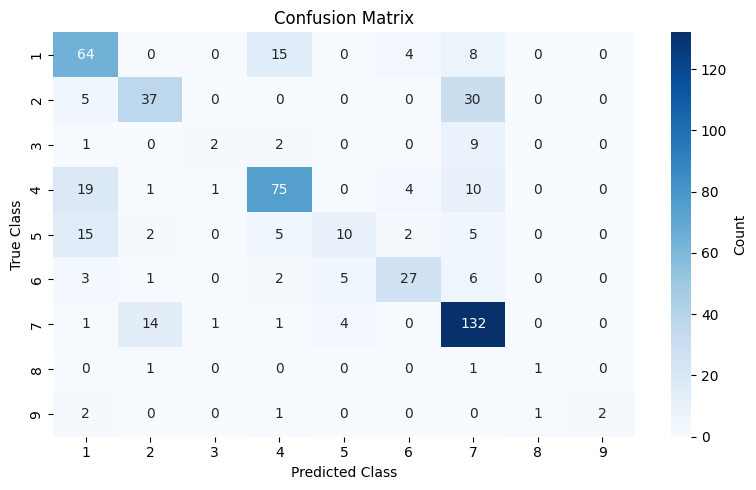

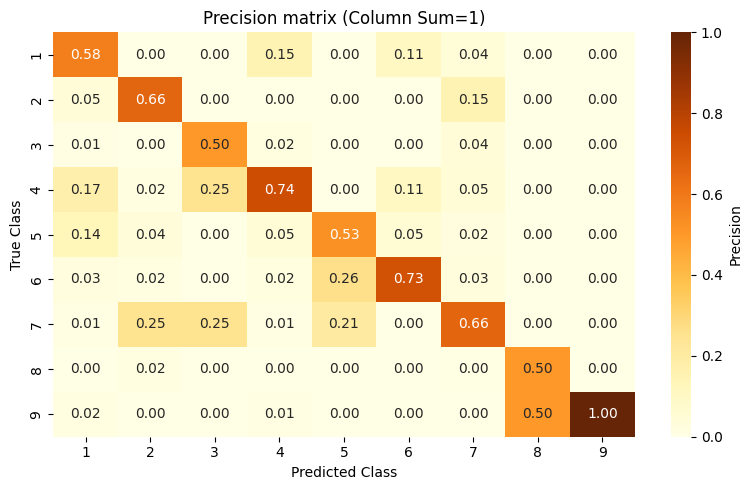

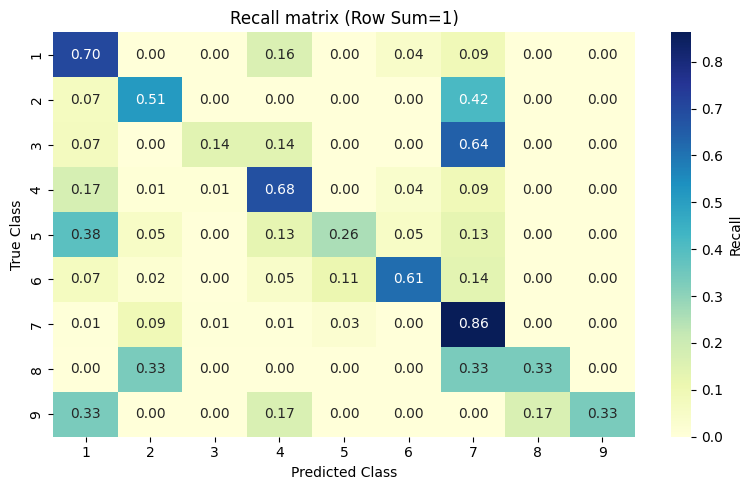

In [114]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

**4.3.2.3. Feature Importance, Correctly Classified point**

In [115]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 5
Predicted Class Probabilities: [[0.1626 0.0329 0.0217 0.2454 0.36   0.1483 0.021  0.0063 0.0018]]
Actual Class : 5
--------------------------------------------------
410 Text feature [421] present in test data point [True]
452 Text feature [multifactorial] present in test data point [True]
470 Text feature [identified] present in test data point [True]
Out of the top 500 features, 3 are present in the query point


**4.3.2.4. Feature Importance, Inorrectly Classified point**

In [118]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0457 0.0878 0.0164 0.047  0.0936 0.0411 0.6552 0.006  0.0074]]
Actual Class : 5
--------------------------------------------------


## 4.4. Linear Support Vector Machines

### 4.4.1. Hyper paramter tuning

For alpha = 1e-05
Log Loss: 1.3001360319087991
For alpha = 0.0001
Log Loss: 1.2309500625468297
For alpha = 0.001
Log Loss: 1.1303883265780081
For alpha = 0.01
Log Loss: 1.1216662253752654
For alpha = 0.1
Log Loss: 1.3245565682202054
For alpha = 1
Log Loss: 1.7047529731697486
For alpha = 10
Log Loss: 1.720358122980219
For alpha = 100
Log Loss: 1.7203581090171214

Tuning complete.



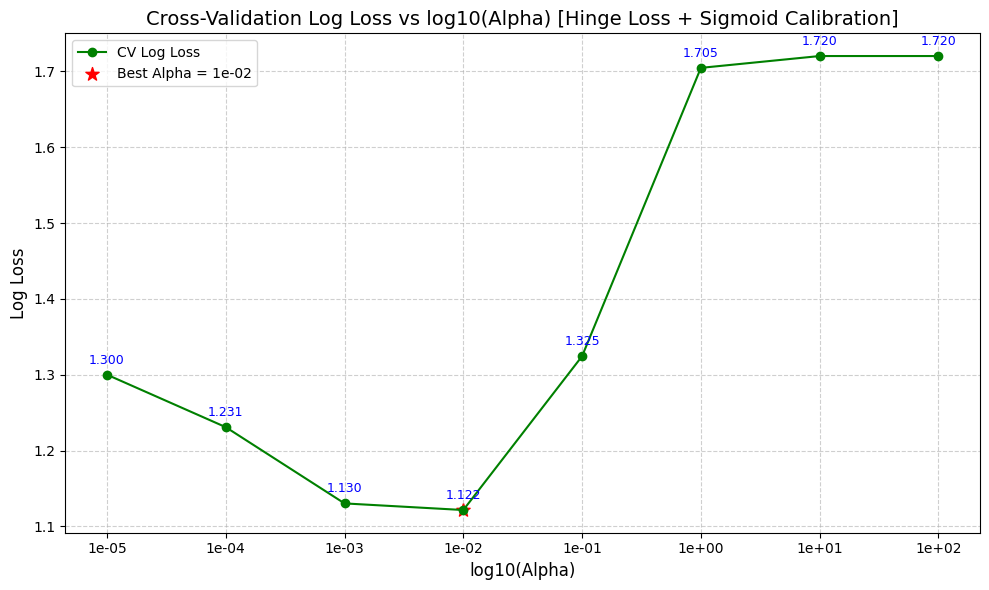


Retraining with best alpha = 1e-02

Performance Summary:
Train Log Loss         : 0.7367
Cross Validation Loss  : 1.1217
Test Log Loss          : 1.1534


In [119]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    err = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(err)
    print("Log Loss:", err)
print("\nTuning complete.\n")

# Convert alpha to log10 scale for plotting
log_alphas = np.log10(alpha)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(log_alphas, cv_log_error_array, marker='o', linestyle='-', color='green', label='CV Log Loss')

# Annotate each point with error
for i, err in enumerate(cv_log_error_array):
    ax.annotate(f"{err:.3f}", (log_alphas[i], err), textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=9, color='blue')

# Highlight best alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha_val = alpha[best_alpha_idx]
ax.scatter(log_alphas[best_alpha_idx], cv_log_error_array[best_alpha_idx],
           color='red', s=100, marker='*', label=f'Best Alpha = {best_alpha_val:.0e}')

# Format plot
ax.set_title("Cross-Validation Log Loss vs log10(Alpha) [Hinge Loss + Sigmoid Calibration]", fontsize=14)
ax.set_xlabel("log10(Alpha)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xticks(log_alphas)
ax.set_xticklabels([f"{a:.0e}" for a in alpha])
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# Retrain model with best alpha
print(f"\nRetraining with best alpha = {best_alpha_val:.0e}")
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha_val, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Evaluate
predict_y_train = sig_clf.predict_proba(train_x_onehotCoding)
predict_y_cv = sig_clf.predict_proba(cv_x_onehotCoding)
predict_y_test = sig_clf.predict_proba(test_x_onehotCoding)

print("\nPerformance Summary:")
print(f"Train Log Loss         : {log_loss(y_train, predict_y_train, labels=clf.classes_):.4f}")
print(f"Cross Validation Loss  : {log_loss(y_cv, predict_y_cv, labels=clf.classes_):.4f}")
print(f"Test Log Loss          : {log_loss(y_test, predict_y_test, labels=clf.classes_):.4f}")


### 4.4.2. Testing model with best hyper parameters

Log loss : 1.1216662253752654
Number of mis-classified points : 0.35150375939849626


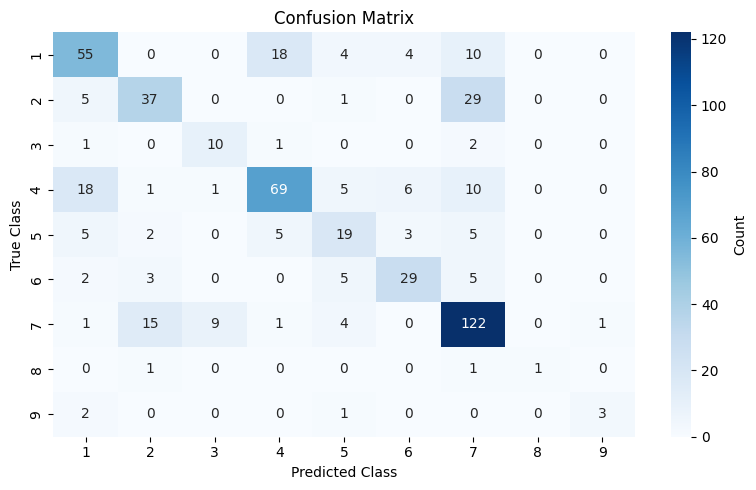

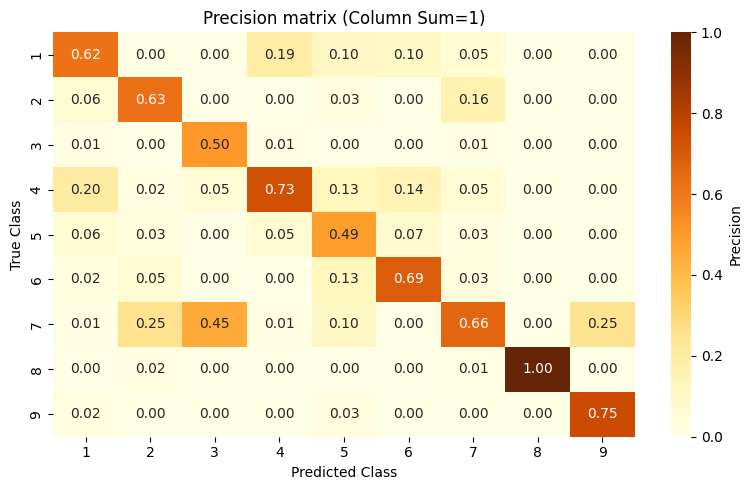

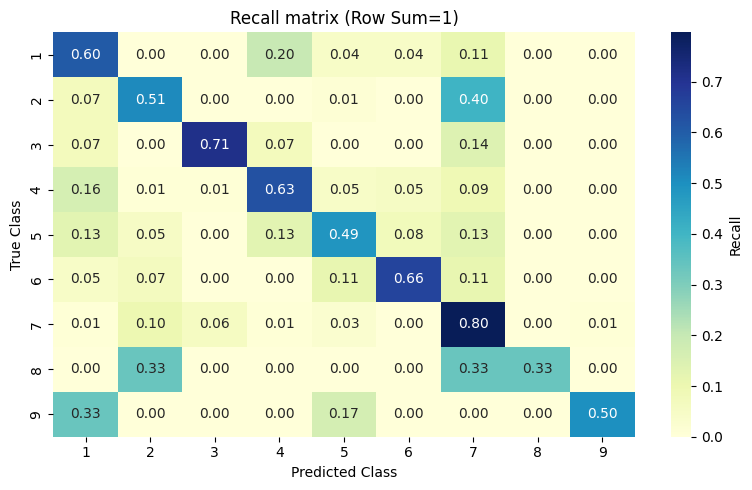

In [120]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.3.3. Feature Importance

**4.3.3.1. For Correctly classified point**

In [121]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 5
Predicted Class Probabilities: [[0.1599 0.0971 0.0255 0.1253 0.3564 0.0777 0.1438 0.0081 0.0062]]
Actual Class : 5
--------------------------------------------------


**4.3.3.2. For Incorrectly classified point**

In [123]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0866 0.0686 0.0169 0.0851 0.078  0.0386 0.6146 0.0058 0.0058]]
Actual Class : 5
--------------------------------------------------


## 4.5 Random Forest Classifier

### 4.5.1. Hyper paramter tuning (With One hot Encoding)

For n_estimators = 100, max_depth = 5
Log Loss: 1.2264

For n_estimators = 100, max_depth = 10
Log Loss: 1.1746

For n_estimators = 200, max_depth = 5
Log Loss: 1.2174

For n_estimators = 200, max_depth = 10
Log Loss: 1.1649

For n_estimators = 500, max_depth = 5
Log Loss: 1.2109

For n_estimators = 500, max_depth = 10
Log Loss: 1.1573

For n_estimators = 1000, max_depth = 5
Log Loss: 1.2104

For n_estimators = 1000, max_depth = 10
Log Loss: 1.1562

For n_estimators = 2000, max_depth = 5
Log Loss: 1.2086

For n_estimators = 2000, max_depth = 10
Log Loss: 1.1545



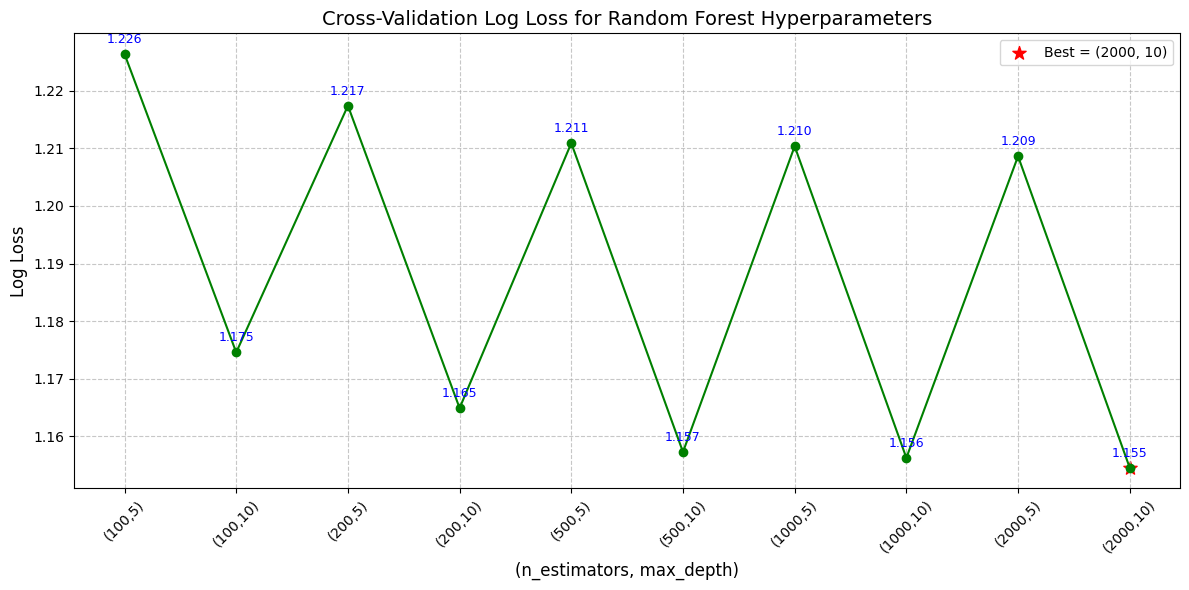


Retraining with best parameters: n_estimators = 2000, max_depth = 10

Performance Summary:
Train Log Loss         : 0.7053
Cross Validation Loss  : 1.1545
Test Log Loss          : 1.1475


In [124]:
alpha = [100, 200, 500, 1000, 2000]
max_depth = [5, 10]

cv_log_error_array = []
param_combo = []

for i in alpha:
    for j in max_depth:
        print(f"For n_estimators = {i}, max_depth = {j}")
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)

        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)

        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)

        cv_log_error_array.append(loss)
        param_combo.append((i, j))
        print(f"Log Loss: {loss:.4f}\n")

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(param_combo))

ax.plot(x, cv_log_error_array, marker='o', linestyle='-', color='green')
ax.set_xticks(x)
ax.set_xticklabels([f"({n},{d})" for n, d in param_combo], rotation=45, fontsize=10)

for i, loss in enumerate(cv_log_error_array):
    ax.annotate(f"{loss:.3f}", (x[i], cv_log_error_array[i]), textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=9, color='blue')

best_idx = np.argmin(cv_log_error_array)
best_n, best_d = param_combo[best_idx]
ax.scatter(x[best_idx], cv_log_error_array[best_idx], color='red', s=100, marker='*',
           label=f"Best = ({best_n}, {best_d})")

ax.set_title("Cross-Validation Log Loss for Random Forest Hyperparameters", fontsize=14)
ax.set_xlabel("(n_estimators, max_depth)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

# Final model training with best parameters
print(f"\nRetraining with best parameters: n_estimators = {best_n}, max_depth = {best_d}")
clf = RandomForestClassifier(n_estimators=best_n, criterion='gini', max_depth=best_d,
                             random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Evaluate
predict_y_train = sig_clf.predict_proba(train_x_onehotCoding)
predict_y_cv = sig_clf.predict_proba(cv_x_onehotCoding)
predict_y_test = sig_clf.predict_proba(test_x_onehotCoding)

print("\nPerformance Summary:")
print(f"Train Log Loss         : {log_loss(y_train, predict_y_train, labels=clf.classes_):.4f}")
print(f"Cross Validation Loss  : {log_loss(y_cv, predict_y_cv, labels=clf.classes_):.4f}")
print(f"Test Log Loss          : {log_loss(y_test, predict_y_test, labels=clf.classes_):.4f}")

### 4.5.2. Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.1648966935175362
Number of mis-classified points : 0.39473684210526316


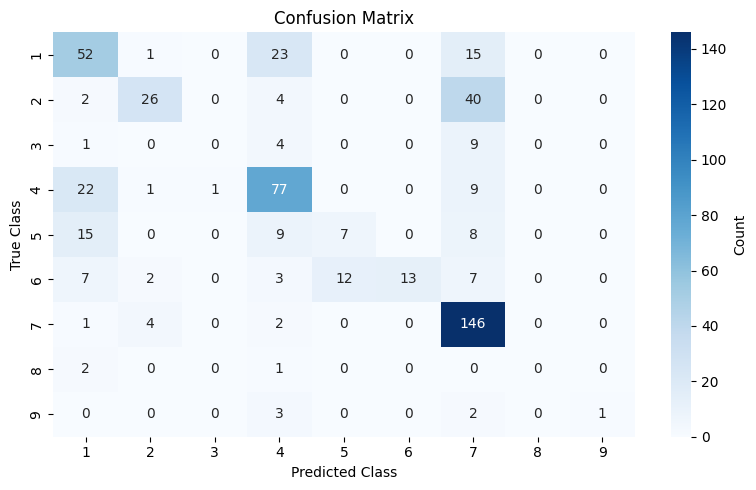

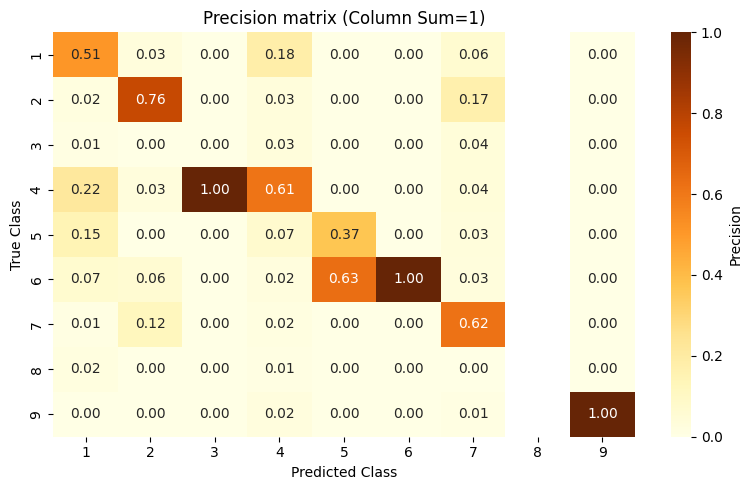

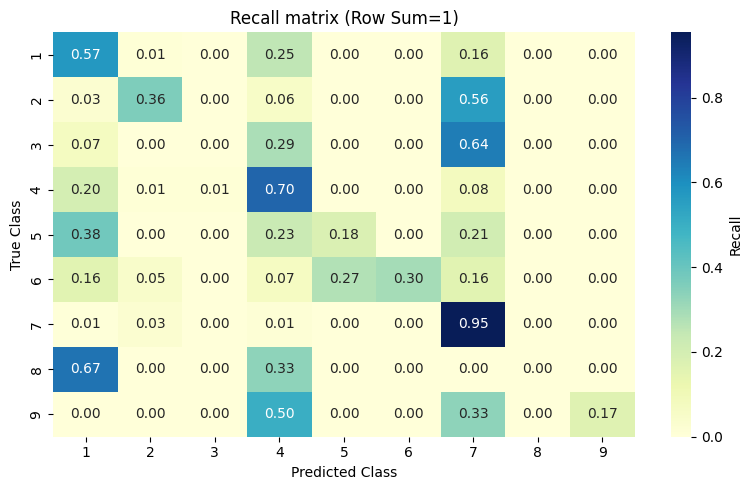

In [125]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.5.3. Feature Importance

**4.5.3.1. Correctly Classified point**

In [132]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.0168 0.16   0.0131 0.0271 0.0266 0.0233 0.7252 0.0047 0.0033]]
Actual Class : 7
--------------------------------------------------


**4.5.3.2. Inorrectly Classified point**

In [130]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)

Predicted Class : 1
Predicted Class Probabilities: [[0.3654 0.0166 0.0263 0.3108 0.1389 0.1064 0.025  0.0046 0.0059]]
Actuall Class : 5
--------------------------------------------------


### 4.5.3. Hyper paramter tuning (With Response Coding)

For n_estimators = 10, max_depth = 2
Log Loss: 2.0174

For n_estimators = 10, max_depth = 3
Log Loss: 1.6738

For n_estimators = 10, max_depth = 5
Log Loss: 1.5182

For n_estimators = 10, max_depth = 10
Log Loss: 1.8352

For n_estimators = 50, max_depth = 2
Log Loss: 1.7486

For n_estimators = 50, max_depth = 3
Log Loss: 1.4524

For n_estimators = 50, max_depth = 5
Log Loss: 1.3188

For n_estimators = 50, max_depth = 10
Log Loss: 1.6596

For n_estimators = 100, max_depth = 2
Log Loss: 1.6665

For n_estimators = 100, max_depth = 3
Log Loss: 1.5159

For n_estimators = 100, max_depth = 5
Log Loss: 1.2291

For n_estimators = 100, max_depth = 10
Log Loss: 1.7268

For n_estimators = 200, max_depth = 2
Log Loss: 1.6408

For n_estimators = 200, max_depth = 3
Log Loss: 1.4922

For n_estimators = 200, max_depth = 5
Log Loss: 1.2878

For n_estimators = 200, max_depth = 10
Log Loss: 1.7177

For n_estimators = 500, max_depth = 2
Log Loss: 1.6964

For n_estimators = 500, max_depth = 3
Log Loss: 1.50

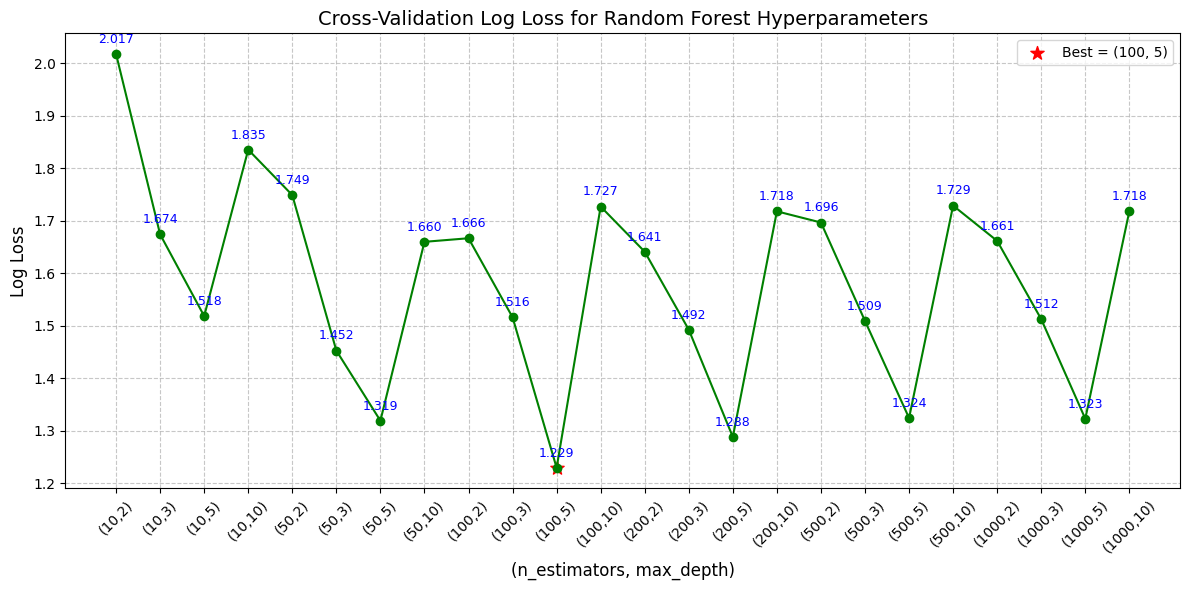


Retraining with best parameters: n_estimators = 100, max_depth = 5

Performance Summary:
Train Log Loss        : 0.0623
CV Log Loss           : 1.2291
Test Log Loss         : 1.2565


In [133]:
alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10]

cv_log_error_array = []
param_combo = []

for i in alpha:
    for j in max_depth:
        print(f"For n_estimators = {i}, max_depth = {j}")
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,
                                     random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)

        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)

        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        loss = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)

        cv_log_error_array.append(loss)
        param_combo.append((i, j))
        print(f"Log Loss: {loss:.4f}\n")
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(param_combo))

ax.plot(x, cv_log_error_array, marker='o', linestyle='-', color='green')
ax.set_xticks(x)
ax.set_xticklabels([f"({n},{d})" for n, d in param_combo], rotation=45, fontsize=10)

for i, loss in enumerate(cv_log_error_array):
    ax.annotate(f"{loss:.3f}", (x[i], cv_log_error_array[i]), textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=9, color='blue')

best_idx = np.argmin(cv_log_error_array)
best_n, best_d = param_combo[best_idx]
ax.scatter(x[best_idx], cv_log_error_array[best_idx], color='red', s=100, marker='*',
           label=f"Best = ({best_n}, {best_d})")

ax.set_title("Cross-Validation Log Loss for Random Forest Hyperparameters", fontsize=14)
ax.set_xlabel("(n_estimators, max_depth)", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nRetraining with best parameters: n_estimators = {best_n}, max_depth = {best_d}")
clf = RandomForestClassifier(n_estimators=best_n, criterion='gini', max_depth=best_d,
                             random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y_train = sig_clf.predict_proba(train_x_responseCoding)
predict_y_cv = sig_clf.predict_proba(cv_x_responseCoding)
predict_y_test = sig_clf.predict_proba(test_x_responseCoding)

print("\nPerformance Summary:")
print(f"Train Log Loss        : {log_loss(y_train, predict_y_train, labels=clf.classes_):.4f}")
print(f"CV Log Loss           : {log_loss(y_cv, predict_y_cv, labels=clf.classes_):.4f}")
print(f"Test Log Loss         : {log_loss(y_test, predict_y_test, labels=clf.classes_):.4f}")


### 4.5.4. Testing model with best hyper parameters (Response Coding)

Log loss : 1.8351548117946204
Number of mis-classified points : 0.7124060150375939


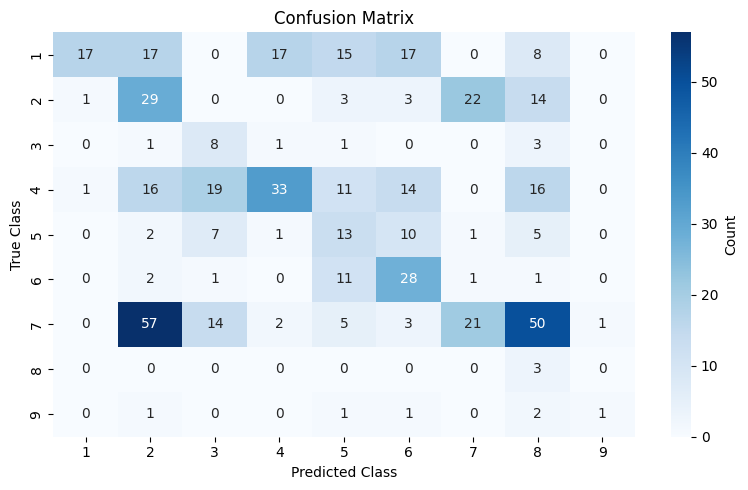

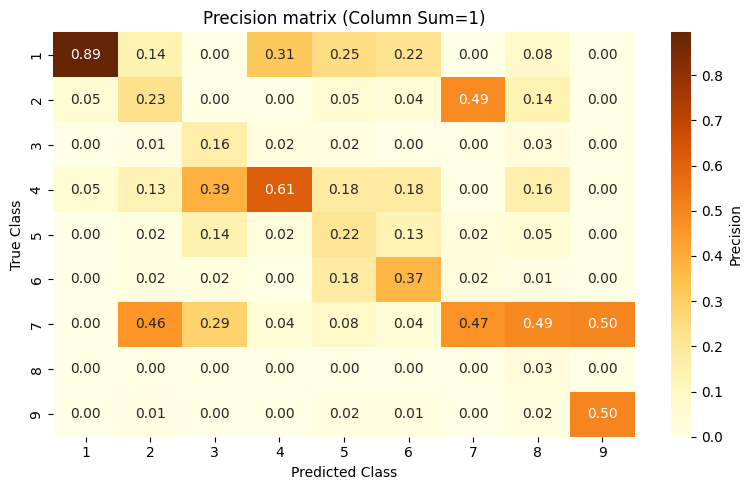

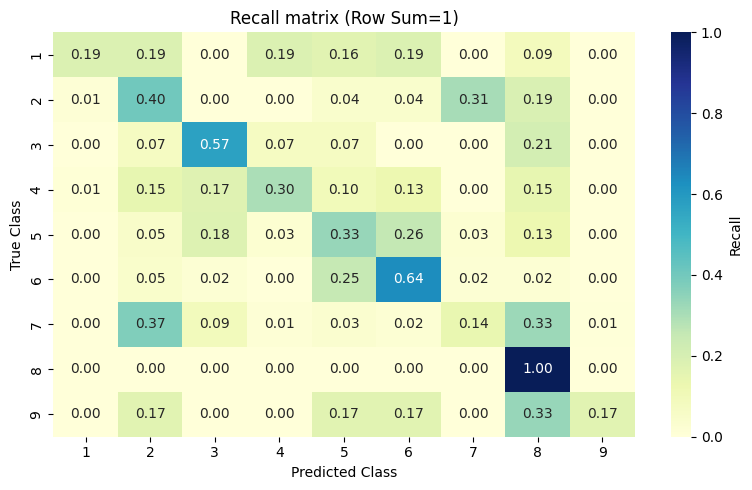

In [135]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='sqrt',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### 4.5.5. Feature Importance

**4.5.5.1. Correctly Classified point**

In [137]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0043 0.004  0.0026 0.0061 0.0029 0.0044 0.97   0.0027 0.0031]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature


**4.5.5.2. Incorrectly Classified**

In [138]:
test_point_index = 2
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.04   0.254  0.0527 0.1896 0.0583 0.0756 0.158  0.149  0.0228]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## 4.6 Stack the models

### 4.6.1 testing with hyper parameter tuning

In [139]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.08
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.721
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.317
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.144
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.374
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.665


### 4.6.2 testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.5061051544558117
Log loss (CV) on the stacking classifier : 1.144087140314585
Log loss (test) on the stacking classifier : 1.1965187139988929
Number of missclassified point : 0.3669172932330827


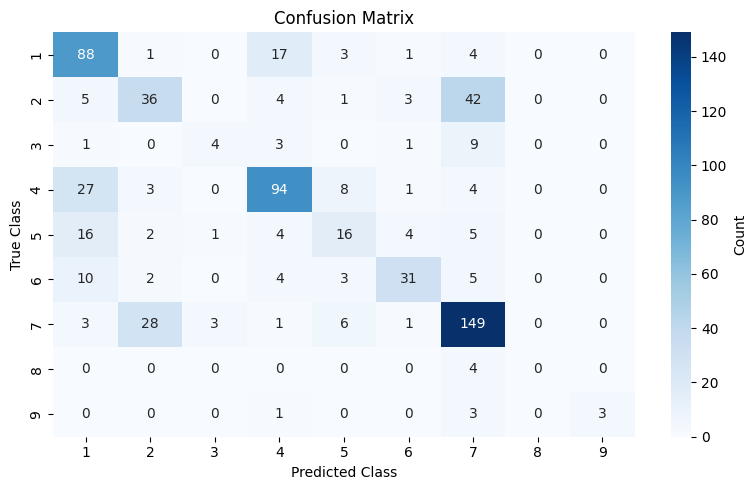

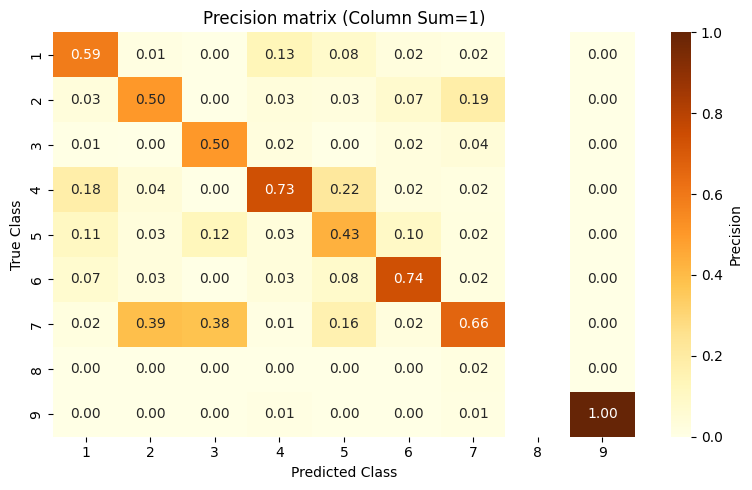

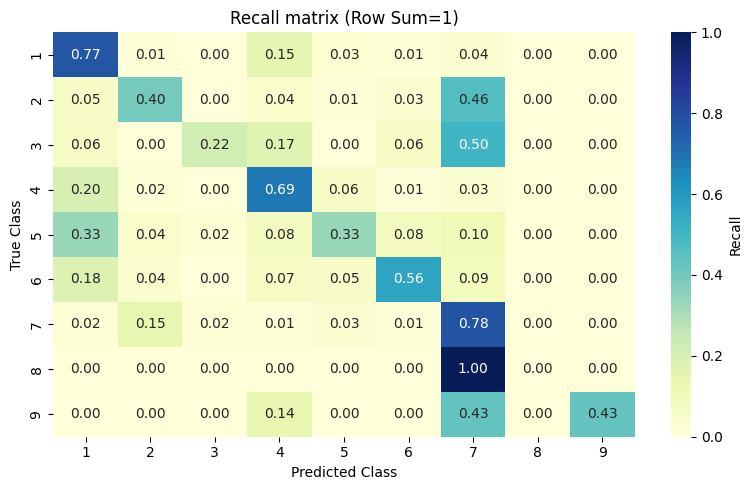

In [140]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### 4.6.3 Maximum Voting classifier

Log loss (train) on the VotingClassifier : 0.8664257582212999
Log loss (CV) on the VotingClassifier : 1.1802482317824416
Log loss (test) on the VotingClassifier : 1.191756565827751
Number of missclassified point : 0.3593984962406015


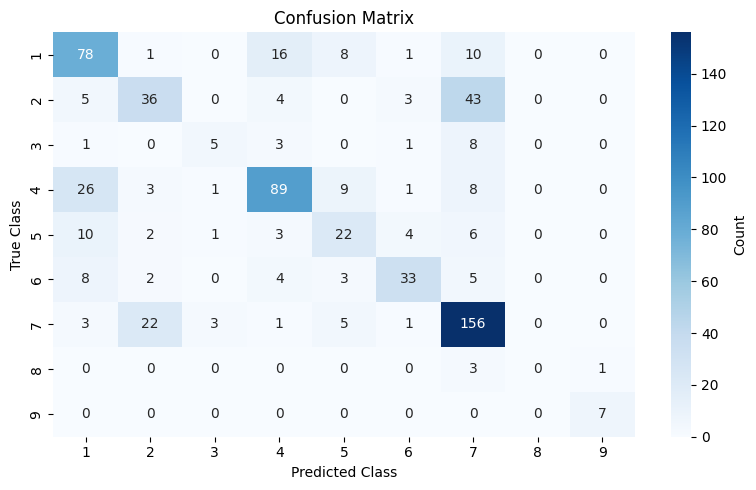

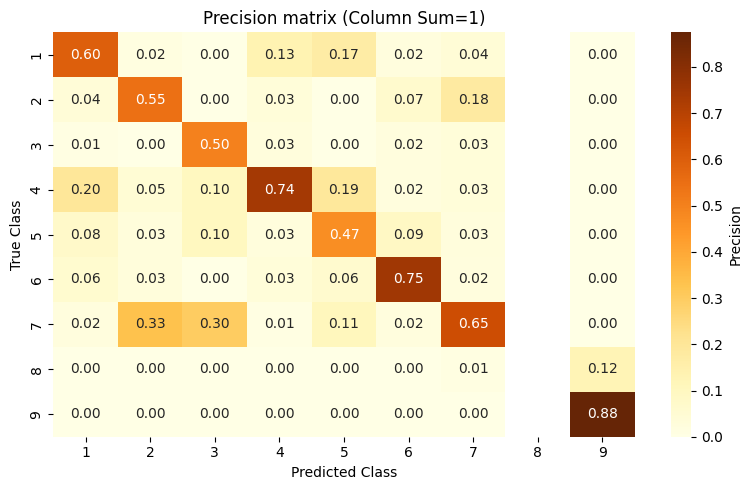

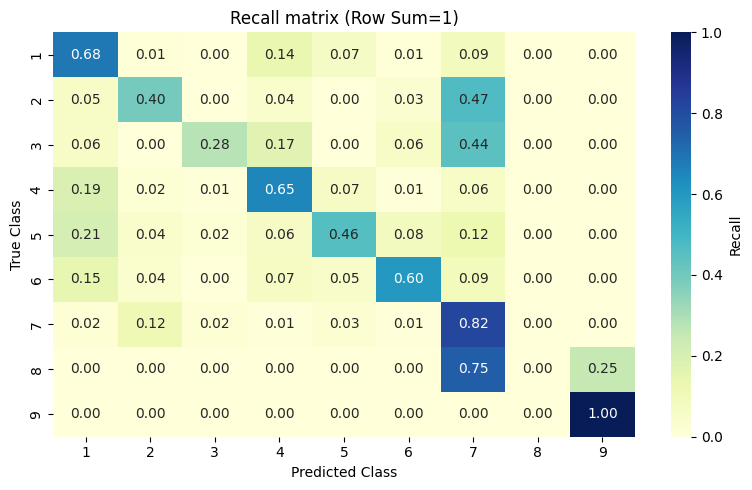

In [141]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))